# Set Up

In [2]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

pd.set_option('display.max_columns',None)
warnings.simplefilter(action='ignore')

In [3]:
def mostrar_adesao(df, columns):
    for col in columns:
        response_pct = df.groupby(col)['Response'].mean().reset_index()
        response_pct['Response'] = (response_pct['Response'] * 100).round(2)
        response_pct = response_pct.rename(columns={'Response': 'Adesão'})

        sample_size = df.groupby(col)['Response'].count().reset_index()
        sample_size = sample_size.rename(columns={'Response': 'Amostra'})

        display(pd.merge(response_pct, sample_size, on=col))

def analisar_distribuicao_categorica(df, colunas_categoricas, target='Response'):
    for coluna in colunas_categoricas:
        plt.figure(figsize=(8, 5))
        sns.countplot(data=df, x=coluna, hue=target)
        plt.title(coluna)
        plt.ylabel('Contagem')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

def z_test_category(df, column,target='Response'):
    converted = df[df[target] == 1][column].value_counts().sort_index()
    total = df[column].value_counts().sort_index()
    
    converted = converted.reindex(total.index, fill_value=0)

    z, p = proportions_ztest(count=converted, nobs=total)

    if p < 0.05:
        print('Resultado:\nH0 rejeitada, diferença estatisticamente significativa')
    else:
        print('Resultado:\nH0 aceita, sem diferença estatística')

    print(f'p: {p}')
    print(f'Z: {z}')

def wilcoxon_test(df, column, target='Response'):
    grupo_1 = df[df[target] == 1][column].dropna()
    grupo_0 = df[df[target] == 0][column].dropna()

    stat, p = mannwhitneyu(grupo_1, grupo_0, alternative='two-sided')
    
    if p < 0.05:
        print('Resultado:\nH₀ rejeitada, diferença estatisticamente significativa')
    else:
        print('Resultado:\nH₀ aceita, sem diferença estatística')
    
    print(f'p: {p}')
    print(f'U: {stat}')

def analisar_distribuicao_numerica(df, colunas_numericas, target='Response'):
    colors = {0: '#1f77b4', 1: '#ff7f0e'}

    for coluna in colunas_numericas:
        shap, p = shapiro(df[coluna].dropna())
        
        if p < 0.05:
            print('Distribuição não normal')
        else:
            print('Distribuição normal')
        print(f'p: {p}')
        print(f'Shapiro: {shap}')

        fig, (box_plot, hist_plot) = plt.subplots(2, 1, figsize=(8, 5), gridspec_kw={'height_ratios': [1, 3]})

        box_plot.boxplot(
            [df[df[target] == r][coluna].dropna() for r in [0, 1]],
            vert=False,
            showmeans=True,
            labels=['Não aderiu', 'Aderiu'],
            patch_artist=True,
            boxprops=dict(facecolor='#e0e0e0')
        )
        box_plot.set_title(coluna)

        for r in [0, 1]:
            hist_plot.hist(
                df[df[target] == r][coluna].dropna(),
                bins='auto',
                alpha=0.6,
                label='Aderiu' if r == 1 else 'Não aderiu',
                color=colors[r]
            )

        hist_plot.legend()
        hist_plot.set_xlabel(coluna)
        hist_plot.set_ylabel('Frequência')
        hist_plot.grid(True, linestyle='--', alpha=0.5)

        plt.tight_layout()
        plt.show()

def interpretar_diferenca(df, column, target='Response'):
    grupo_1 = df[df[target] == 1][column].dropna()
    grupo_0 = df[df[target] == 0][column].dropna()

    mediana_1 = grupo_1.median()
    mediana_0 = grupo_0.median()

    print(f'Mediana (grupo que aderiu): {mediana_1}')
    print(f'Mediana (grupo que não aderiu): {mediana_0}')

    if mediana_1 > mediana_0:
        print('Usuários que aderiram tendem a ter valores maiores dessa variável')
    elif mediana_1 < mediana_0:
        print('Usuários que aderiram tendem a ter valores menores dessa variável')
    else:
        print('As medianas são iguais entre os grupos')

def response_countplot(df, category_col, title=None, category_order=None, figsize=(8, 5)):
    plt.figure(figsize=figsize)
    sns.countplot(data=df, x=category_col, hue='Response', order=category_order)
    plt.title(title if title else f'Contagem por {category_col}')
    plt.xlabel(category_col)
    plt.ylabel('Contagem')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

def response_rateplot(df, category_col, title=None, category_order=None, figsize=(8, 5)):
    response_rate = df.groupby(category_col)['Response'].mean().reset_index()
    response_rate['Response'] = (response_rate['Response'] * 100).round(2)

    if category_order:
        response_rate[category_col] = pd.Categorical(
            response_rate[category_col],
            categories=category_order,
            ordered=True
        )
        response_rate = response_rate.sort_values(category_col)

    plt.figure(figsize=figsize)
    sns.lineplot(data=response_rate, x=category_col, y='Response', marker='o', color='black')
    plt.title(title if title else f'Taxa de Adesão por {category_col}')
    plt.xlabel(category_col)
    plt.ylabel('% de Resposta (Adesão)')
    plt.ylim(bottom=0)  # Limite inferior fixado em 0
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [4]:
df = pd.read_csv('ml_project1_data.csv')
print(df.shape)
df.head()

(2240, 29)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


|Coluna|Descrição|
|---|---|
|ID| Id do usuário|
|Year_Birth| Ano de nasciemnto do usuário|
|Education| Nível de educação do cliente|
|Marital_Status| Estado civil do cliente|
|Income| Renda anual da família do cliente|
|Kidhome| Número de crianças pequenas na casa do cliente|
|Teenhome| Número de adolescentes na casa do cliente|
|DtCustomer| Data de cadastro do cliente na empresa|
|Recency| Número de dias desde a última compra|
|MntWines| Valor gasto em vinhos nos últimos 2 anos|
|MntFruits| Valor gasto em frutas nos últimos 2 anos|
|MntMeatProducts| Valor gasto em produtos de carne nos últimos 2 anos|
|MntFishProducts| Valor gasto em produtos de peixe nos últimos 2 anos|
|MntSweetProducts| Valor gasto em produtos doces nos últimos 2 anos|
|MntGoldProds| Valor gasto em produtos de ouro nos últimos 2 anos|
|NumDealsPurchases| Número de compras feitas com desconto|
|NumWebPurchases| Número de compras feitas através do site da empresa|
|NumCatalogPurchases| Número de compras feitas através de catálogo|
|NumStorePurchases| Número de compras feitas diretamente nas lojas|
|NumWebVisitsMonth| Número de visitas ao site da empresa no último mês|
|AcceptedCmp1| 1 se o cliente aceitou a oferta na 1ª campanha, 0 caso contrário|
|AcceptedCmp2| 1 se o cliente aceitou a oferta na 2ª campanha, 0 caso contrário|
|AcceptedCmp3| 1 se o cliente aceitou a oferta na 3ª campanha, 0 caso contrário|
|AcceptedCmp4| 1 se o cliente aceitou a oferta na 4ª campanha, 0 caso contrário|
|AcceptedCmp5| 1 se o cliente aceitou a oferta na 5ª campanha, 0 caso contrário|
|Complain| 1 se o cliente reclamou nos últimos 2 anos, 0 caso contrário|
|Z_CostContact| Custo de contato normalizado|
|Z_Revenue| Receita por usuário normalizada|
|Response (resposta)| 1 se o cliente aceitou a oferta na última campanha, 0 caso |contrário

# Pré-processamento

In [5]:
# Checagem do target
print('Taxa de adesão: ',round(df['Response'].sum()*100/len(df),2))
print('Tamanho da amostra: ', df['Response'].sum())

Taxa de adesão:  14.91
Tamanho da amostra:  334


In [6]:
# Os nomes das colunas estão em convenções diferentes

# Padronizando com camel case
df.columns = df.columns.str.replace('_','').str.replace('Prods','Products')
df = df.rename(columns={'Kidhome':'KidHome','Teenhome':'TeenHome'})

In [7]:
# Checagem da tipagem dos dados
df.dtypes

ID                       int64
YearBirth                int64
Education               object
MaritalStatus           object
Income                 float64
KidHome                  int64
TeenHome                 int64
DtCustomer              object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProducts          int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
ZCostContact             int64
ZRevenue                 int64
Response                 int64
dtype: object

In [8]:
# O DtCustomer é uma coluna de data, mas está como objeto

# Ajustando DtCustomer para datetime
df['DtCustomer'] = pd.to_datetime(df['DtCustomer'], errors='coerce')

In [9]:
# Checagem de nulos
df.isna().sum()

ID                      0
YearBirth               0
Education               0
MaritalStatus           0
Income                 24
KidHome                 0
TeenHome                0
DtCustomer              0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProducts         0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
ZCostContact            0
ZRevenue                0
Response                0
dtype: int64

In [10]:
# Existem 24 registros nulos no Income

# Corrigindo Income nulos por meio da mediana
df.loc[df['Income'].isna(),'Income'] = df['Income'].median()

In [11]:
# Checagem de duplicatas
df.duplicated().sum()

0

In [12]:
# Garantido a tipagem correta para a análise
dados_categoricos = [
    'Education', 'MaritalStatus', 'KidHome', 'TeenHome', 'AcceptedCmp1',
    'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Complain'
]
dados_numericos = [
    'YearBirth', 'Income', 'Recency', 'MntWines', 'MntFruits',
    'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProducts', 
    'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
    'NumWebVisitsMonth'
]

for col in dados_categoricos:
    df[col] = df[col].astype('object')
for col in dados_numericos:
    df[col] = df[col].astype('int64')

# EDA

Entender o impacto de cada veriavel no target

## Dados categóricos

Metodologia:
1. Checar se valores únicos de cada coluna categórica e corrigir se necessario
2. Analisar a frequência das categorias em relação ao target
3. Formular e testar hipóteses

In [13]:
# Overview dos dados categoricos
df[dados_categoricos].describe().T

,count,unique,top,freq
Education,2240,5,Graduation,1127
MaritalStatus,2240,8,Married,864
KidHome,2240,3,0,1293
TeenHome,2240,3,0,1158
AcceptedCmp1,2240,2,0,2096
AcceptedCmp2,2240,2,0,2210
AcceptedCmp3,2240,2,0,2077
AcceptedCmp4,2240,2,0,2073
AcceptedCmp5,2240,2,0,2077
Complain,2240,2,0,2219


### Checando valores únicos

In [14]:
for i in dados_categoricos:
    print(df[i].value_counts(),'\n')

Education
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: count, dtype: int64 

MaritalStatus
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 

KidHome
0    1293
1     899
2      48
Name: count, dtype: int64 

TeenHome
0    1158
1    1030
2      52
Name: count, dtype: int64 

AcceptedCmp1
0    2096
1     144
Name: count, dtype: int64 

AcceptedCmp2
0    2210
1      30
Name: count, dtype: int64 

AcceptedCmp3
0    2077
1     163
Name: count, dtype: int64 

AcceptedCmp4
0    2073
1     167
Name: count, dtype: int64 

AcceptedCmp5
0    2077
1     163
Name: count, dtype: int64 

Complain
0    2219
1      21
Name: count, dtype: int64 



In [15]:
# A coluna MaritalStatus tem categorias diferentes com o mesmo significado, além de outras sem sentido

# Padronizando as categorias da coluna com o mesmo significado
df.loc[df['MaritalStatus']=='Alone','MaritalStatus'] = 'Single'

# Transformando as sem sentido em Other
marital_status_outros = ['Absurd','YOLO']
df['MaritalStatus'] = df['MaritalStatus'].apply(lambda x: 'Other' if x in marital_status_outros else x)

### Análise de frequência

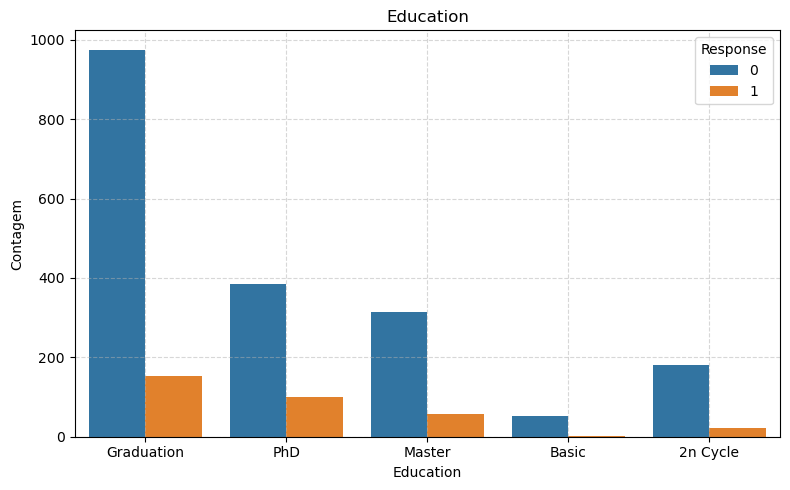

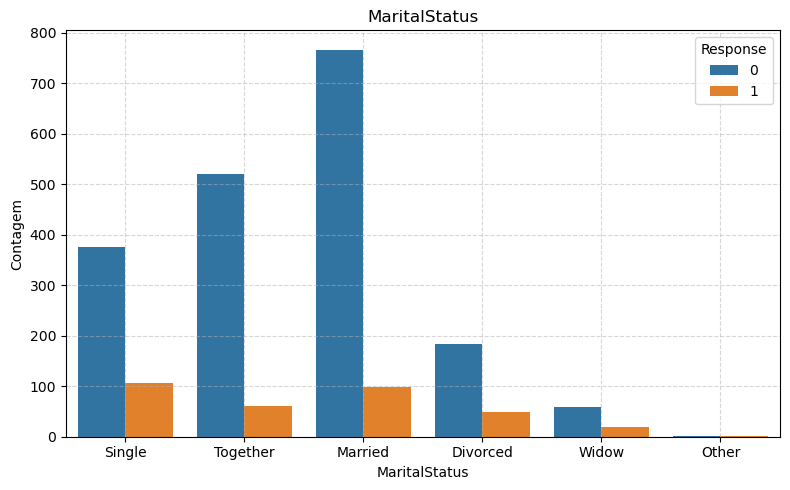

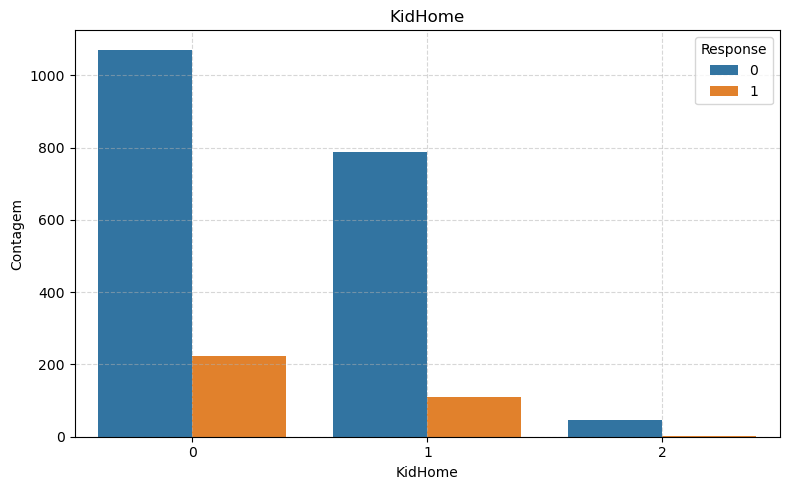

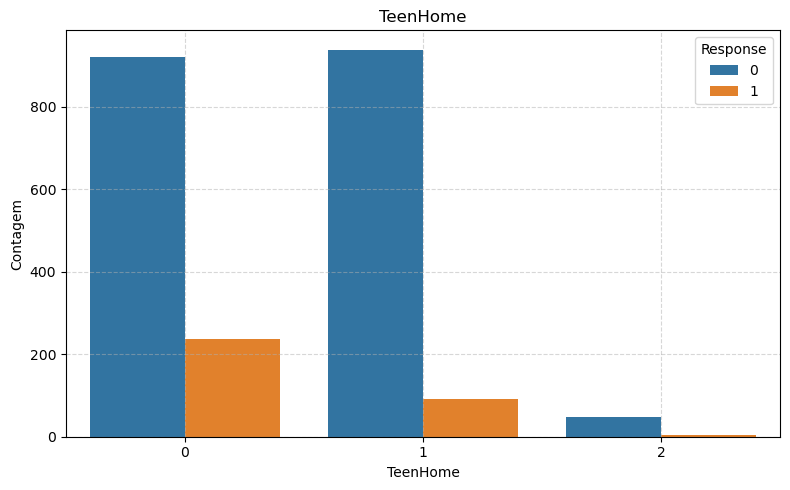

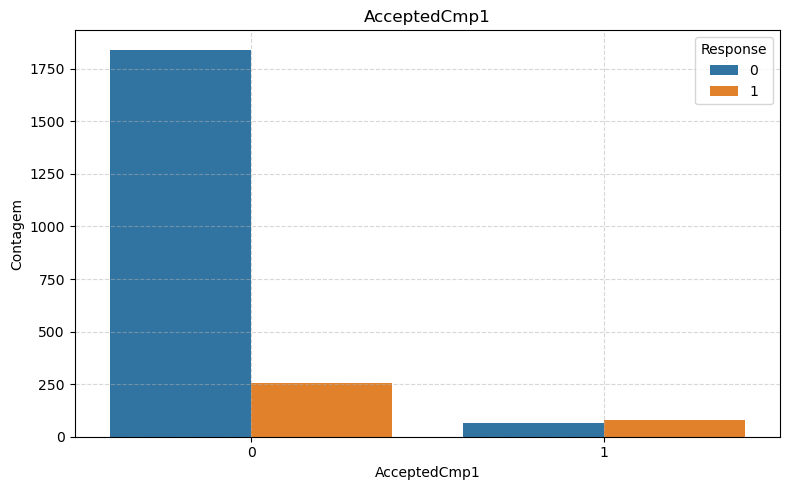

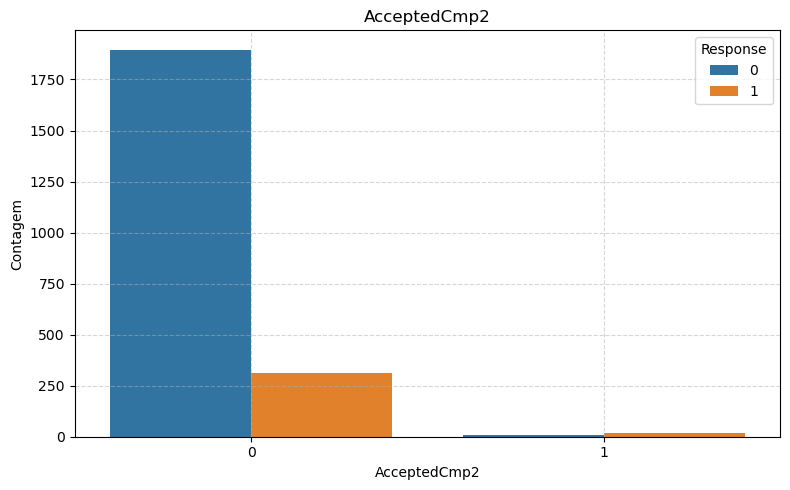

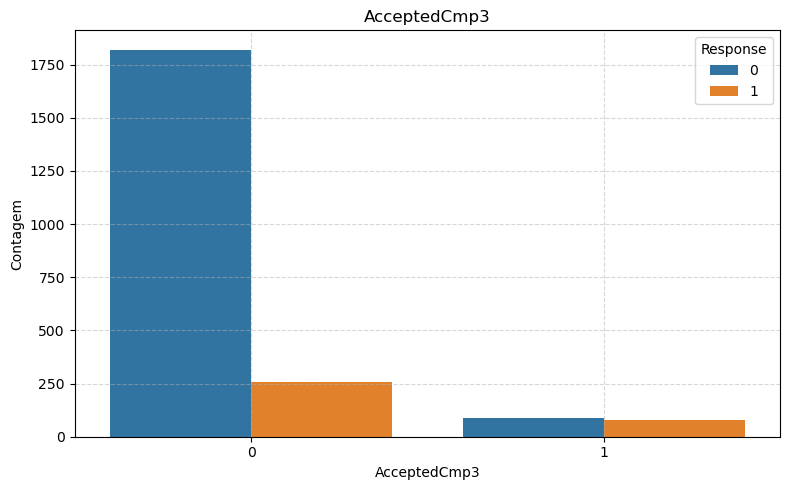

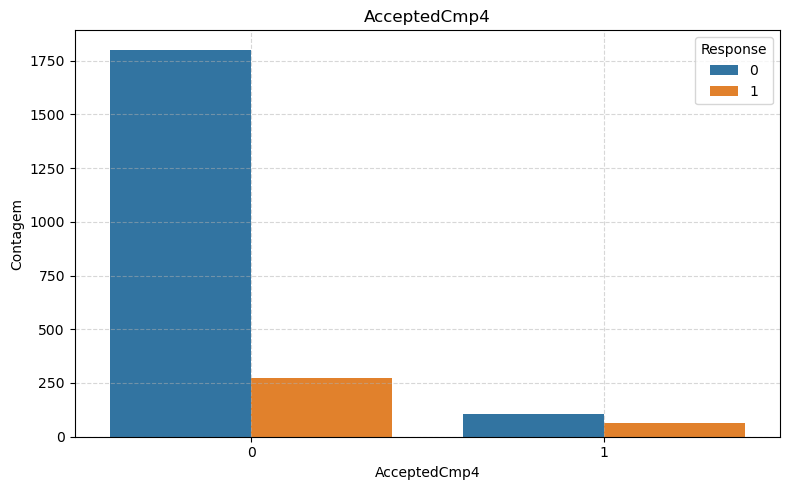

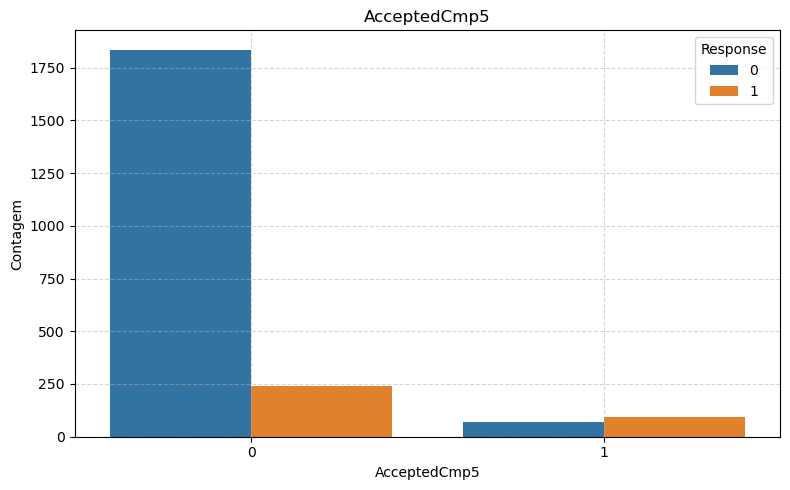

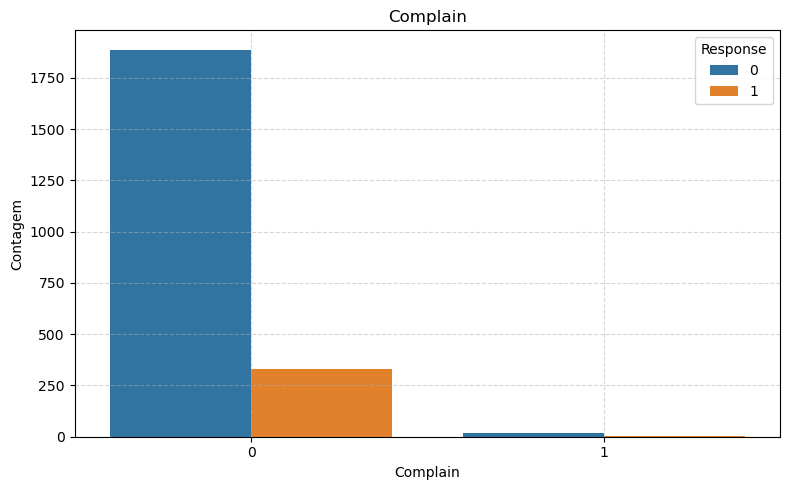

In [16]:
analisar_distribuicao_categorica(df, dados_categoricos)

### Hipóteses

#### Educação
H0: Usuários com maior grau de escolaridade têm a mesma chance de adesão a campanhas que os usuários com menor escolaridade

H1: Usuários com maior grau de escolaridade tem maior chance de adesão a novas campanhas

In [17]:
# Criando grupos de escolaridade baixa, media e alta
education_map = {
    'Basic': 'Low Education',
    'Graduation': 'Medium Education',
    '2n Cycle': 'Medium Education',
    'Master': 'High Education',
    'PhD': 'High Education'
}

df['EducationGroup'] = df['Education'].map(education_map)

# Criando uma flag indicando alta escolaridade
high_education = ['Master','PhD']

df['IsHighEducation'] = df['Education'].isin(high_education).astype(int).astype(object)

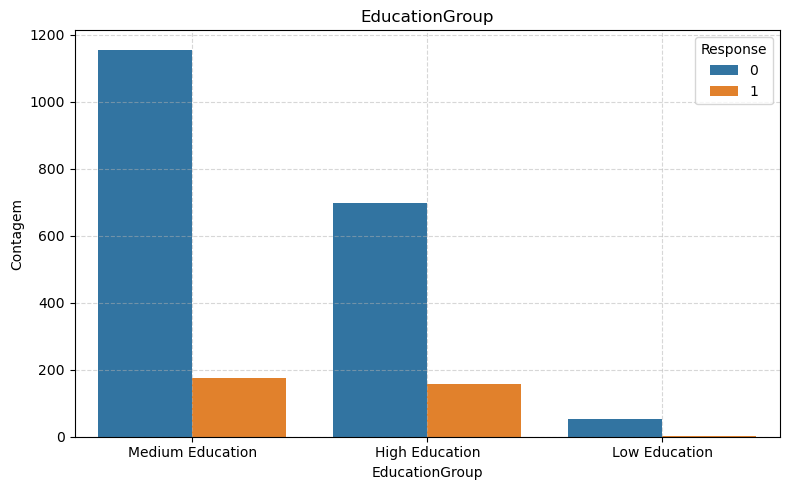

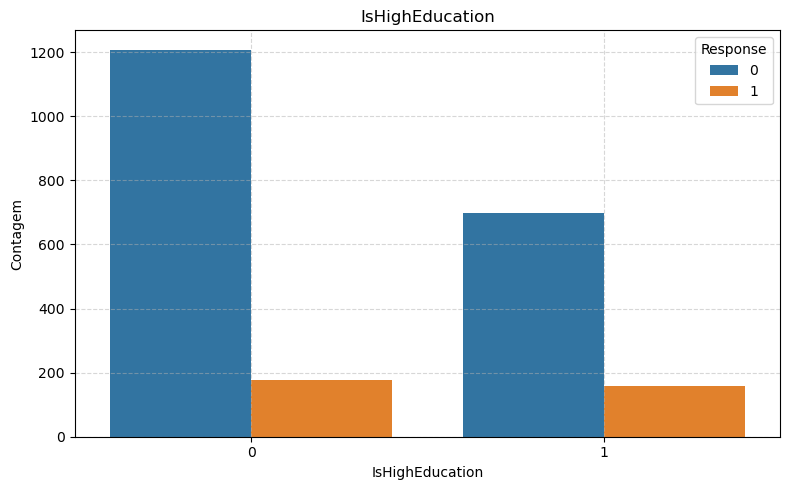

In [18]:
analisar_distribuicao_categorica(df, ['EducationGroup','IsHighEducation'])

In [19]:
mostrar_adesao(df, ['IsHighEducation'])

,IsHighEducation,Adesão,Amostra
0,0,12.72,1384
1,1,18.46,856


In [20]:
# A taxa de adesão é realemente maior para niveis educacionais maiores

# Fazendo o teste Z para ter certeza de que a diferença é significativa
z_test_category(df,'IsHighEducation')

Resultado:
H0 rejeitada, diferença estatisticamente significativa
p: 0.00020992049489702952
Z: -3.7067687056125234



#### Estado civil

H0: A chance de adesão a campanhas é igual entre usuários com e sem parceiros

H1: Usuários sem parceiros têm maior chance de adesão a campanhas do que os que possuem parceiros

In [21]:
# Criando uma flag indicando se não tem parceiro
no_partner_statuses = ['Single', 'Divorced', 'Widow', 'Other']

df['IsAlone'] = df['MaritalStatus'].isin(no_partner_statuses).astype(int).astype(object)

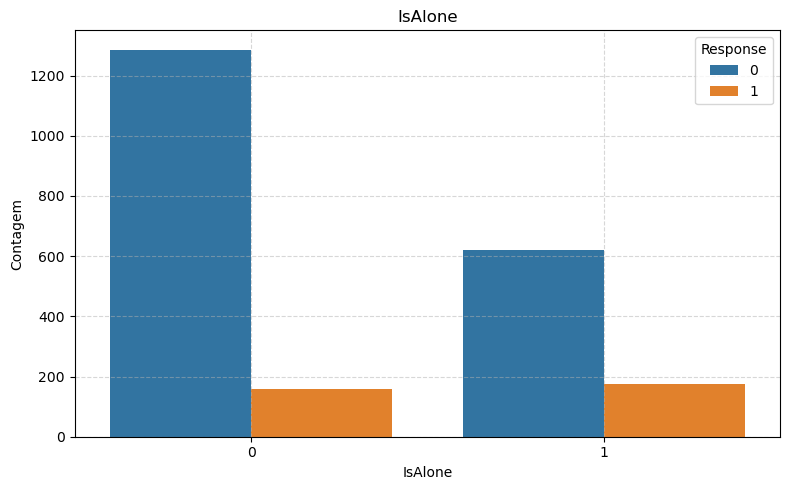

In [22]:
analisar_distribuicao_categorica(df, ['IsAlone'])

In [23]:
mostrar_adesao(df, ['IsAlone'])

,IsAlone,Adesão,Amostra
0,0,10.94,1444
1,1,22.11,796


In [24]:
# O grupo sem parceiro tem uma taxa de adesão duas vezes maior

# Fazendo o teste Z para ter certeza de que a diferença é significativa
z_test_category(df,'IsAlone')

Resultado:
H0 rejeitada, diferença estatisticamente significativa
p: 1.2220433437438347e-12
Z: -7.10285643592785


#### Filhos

H0: A chance de adesão a campanhas é igual entre usuários com e sem filhos

H1: Usuários sem filhos têm maior chance de adesão a campanhas do que os que têm filhos

In [25]:
# Olhar para crianças e adolecentes de forma separada pode estar dispersando o dado

filhos = ['KidHome','TeenHome']

# Criando coluna com a quantidade de filhos
df['ChildrenSum'] = df[filhos].sum(axis=1).astype(object)

# Criando coluna com flag de filho
df['HaveChildren'] = df[filhos].any(axis=1).astype(int).astype(object)

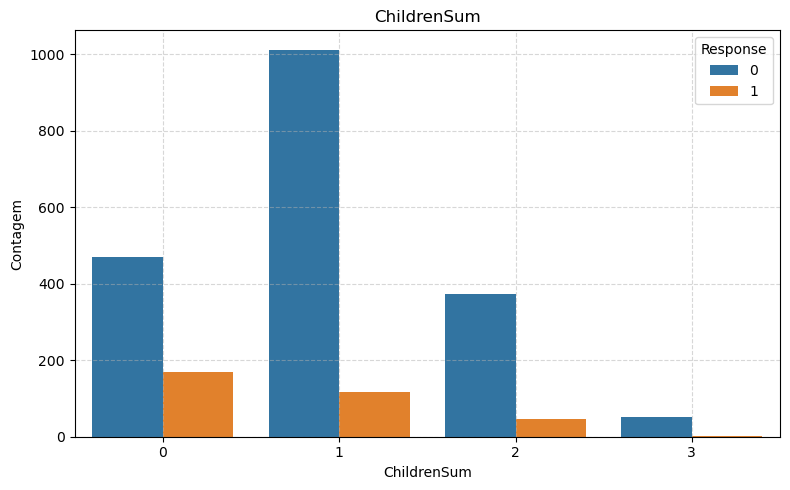

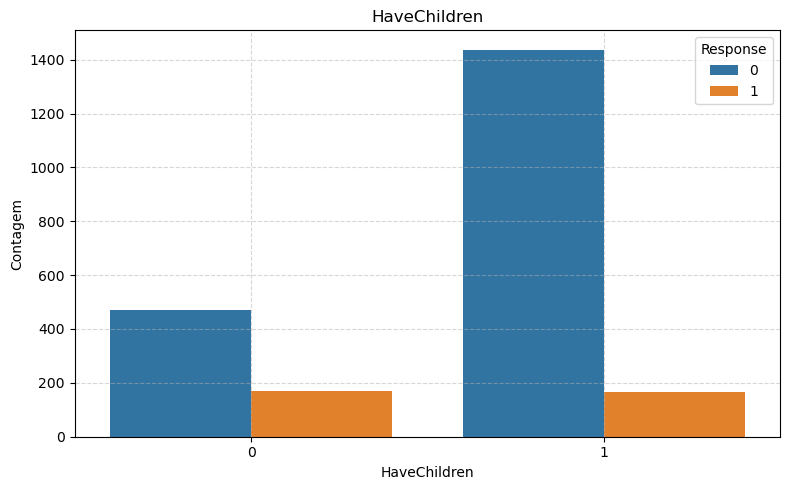

In [26]:
# Taxas de adesão por usuários com e sem filhos
analisar_distribuicao_categorica(df,['ChildrenSum','HaveChildren'])

In [27]:
# Taxas de adesão por usuários com e sem filhos
mostrar_adesao(df,['HaveChildren'])

,HaveChildren,Adesão,Amostra
0,0,26.49,638
1,1,10.30,1602


In [28]:
# Existe uma progressão invesa no numero de filhos e a probabilidade de adesão a uma nova campanha 
# Usuários sem filhos tem quase tres vezes mais chance de aderir a uma nova campanha

# Fazendo o teste Z para ter certeza de que a diferença é significativa
z_test_category(df,'HaveChildren')

Resultado:
H0 rejeitada, diferença estatisticamente significativa
p: 2.768048211095184e-22
Z: 9.708714943908722


#### Campanhas anteriores

H0: A chance de adesão a novas campanhas é igual, independentemente da adesão em campanhas anteriores

H1: Usuários que aderiram a campanhas anteriores têm maior chance de aderir a novas campanhas

In [29]:
# Olhar a adesão as companhas antigas de forma separada pode estar dispersando a informação

campanhas_anteriores = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']

# Criando coluna com a somad de adesões a companhas anteriores
df['AcceptedCmpSum'] = df[campanhas_anteriores].sum(axis=1).astype(object)

# Criando coluna com flag de adesão a qualquer campanha anterior
df['IsAcceptedAny'] = df[campanhas_anteriores].any(axis=1).astype(int).astype(object)

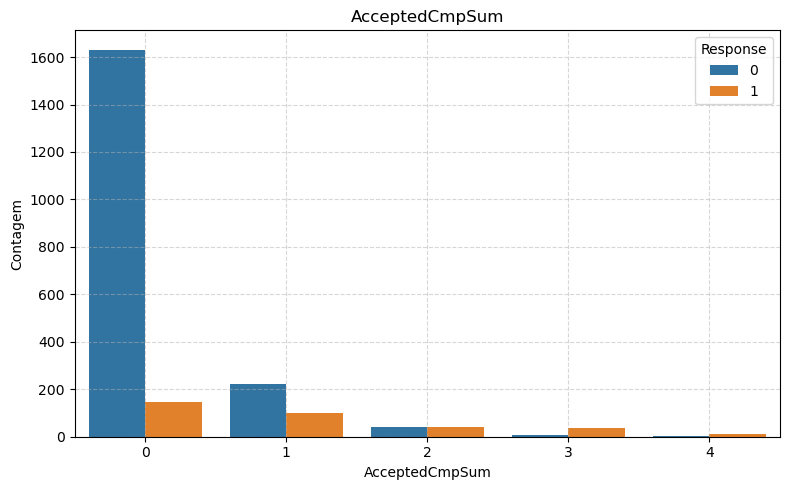

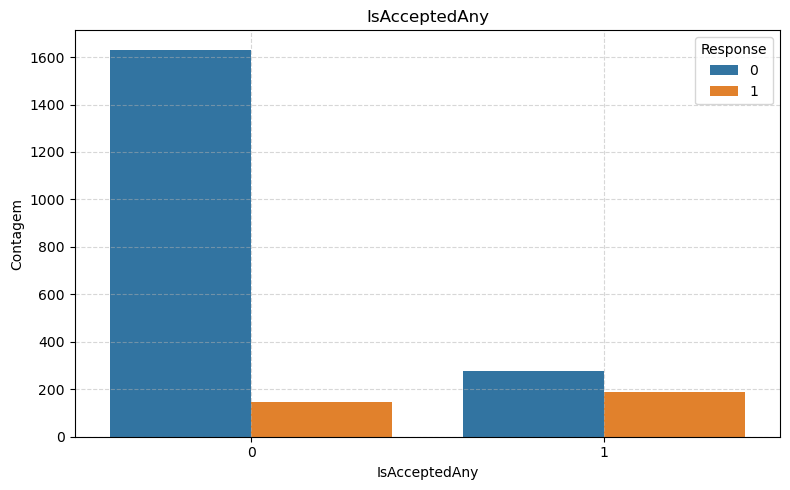

In [30]:
# Taxas de adesão por status de campanhas passadas
analisar_distribuicao_categorica(df,['AcceptedCmpSum','IsAcceptedAny'])

In [31]:
# Taxas de adesão por status de campanhas passadas
mostrar_adesao(df,['IsAcceptedAny'])

,IsAcceptedAny,Adesão,Amostra
0,0,8.22,1777
1,1,40.60,463


In [32]:
# Há uma relação positiva entre o número de campanhas já aderidas e a probabilidade de adesão a uma nova campanha
# Usuários que já participaram de pelo menos uma campanha no passado têm uma probabilidade quatro vezes maior de aderir a uma nova campanha, em comparação com quem nunca participou

# Fazendo o teste Z para ter certeza de que a diferença é significativa
z_test_category(df,'IsAcceptedAny')

Resultado:
H0 rejeitada, diferença estatisticamente significativa
p: 5.169936222533743e-68
Z: -17.426753106746038


#### Reclamações

H0: A chance de adesão a campanhas é igual entre usuários com e sem histórico de reclamações

H1: Usuários sem reclamação têm maior chance de adesão a campanhas do que os que reclamaram

In [33]:
# A distribuição do Complain não sujere diferenças significativas em relação ao target

# Taxas de adesão por reclamações
mostrar_adesao(df,['Complain'])

,Complain,Adesão,Amostra
0,0,14.92,2219
1,1,14.29,21


In [34]:
# Fazendo o teste Z para ter certeza de que a diferença é significativa
z_test_category(df,'Complain')

Resultado:
H0 aceita, sem diferença estatística
p: 0.93561032917203
Z: 0.08078827954116534


## Dados numéricos

Metodologia:

1. Checar outliers e corrigir se necessario
2. Analisar a distribuição em relação ao target e testar normalidade
3. Formular e testar hipóteses

In [35]:
# Overview dos dados numericos
df[dados_numericos].describe().T

,count,mean,std,min,25%,50%,75%,max
YearBirth,2240.0,1968.805804,11.984069,1893.0,1959.00,1970.0,1977.00,1996.0
Income,2240.0,52237.970089,25037.956074,1730.0,35538.75,51381.0,68289.75,666666.0
Recency,2240.0,49.109375,28.962453,0.0,24.00,49.0,74.00,99.0
MntWines,2240.0,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0
MntFruits,2240.0,26.302232,39.773434,0.0,1.00,8.0,33.00,199.0
MntMeatProducts,2240.0,166.950000,225.715373,0.0,16.00,67.0,232.00,1725.0
MntFishProducts,2240.0,37.525446,54.628979,0.0,3.00,12.0,50.00,259.0
MntSweetProducts,2240.0,27.062946,41.280498,0.0,1.00,8.0,33.00,263.0
MntGoldProducts,2240.0,44.021875,52.167439,0.0,9.00,24.0,56.00,362.0
NumDealsPurchases,2240.0,2.325000,1.932238,0.0,1.00,2.0,3.00,15.0


### Checando outliers

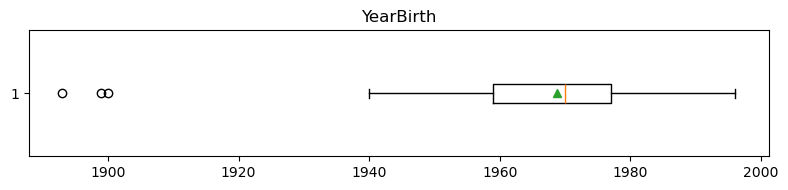

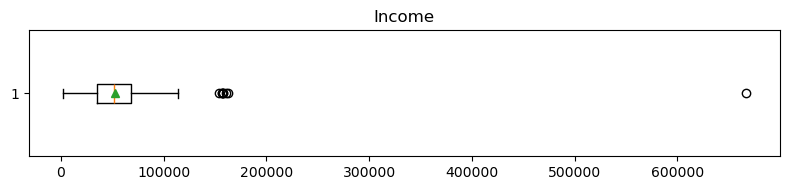

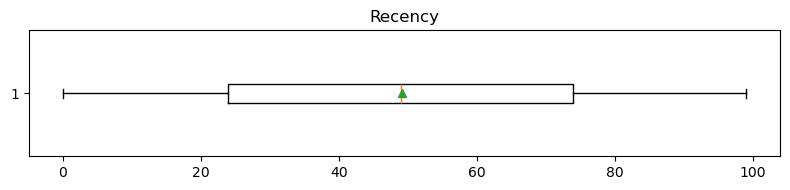

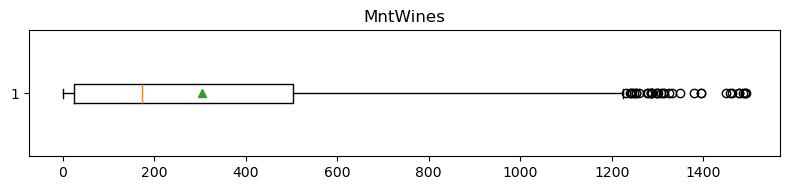

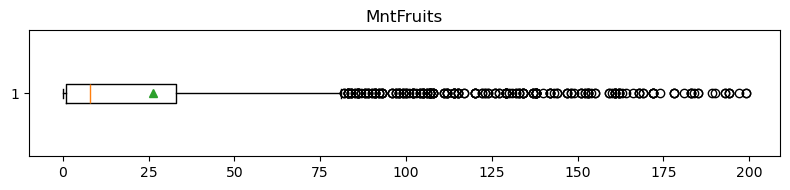

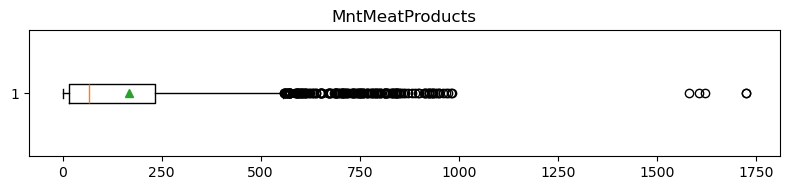

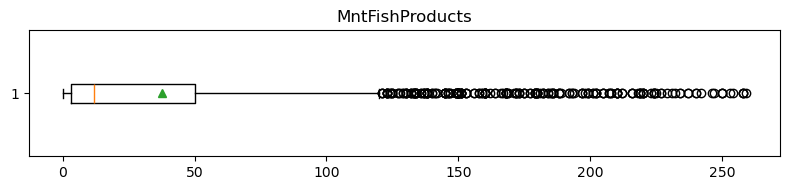

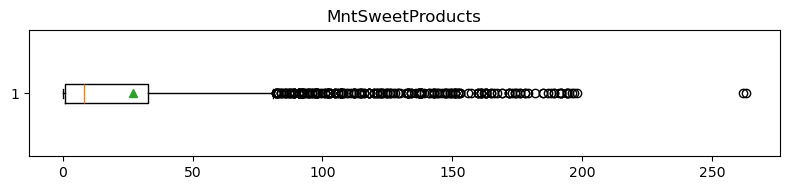

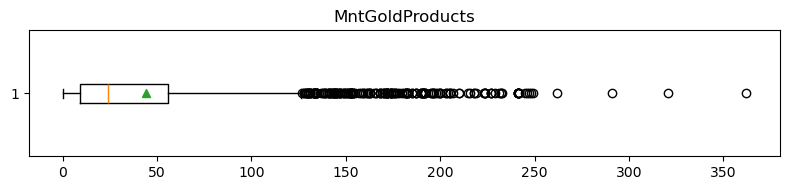

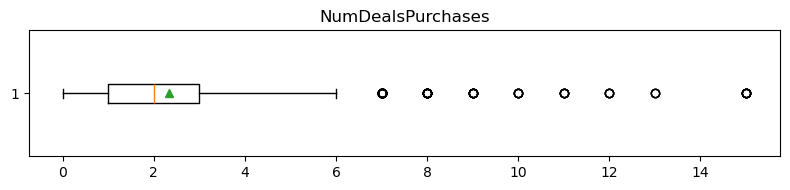

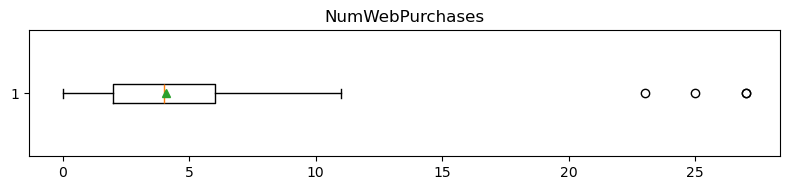

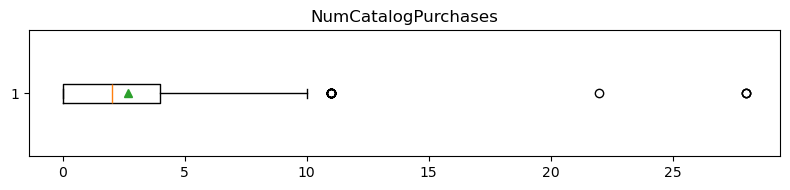

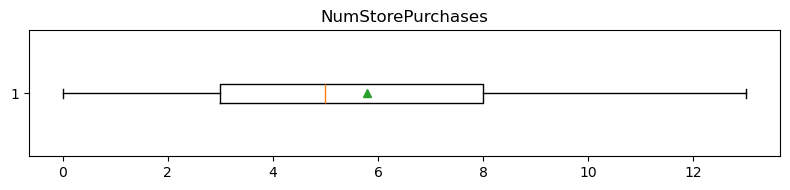

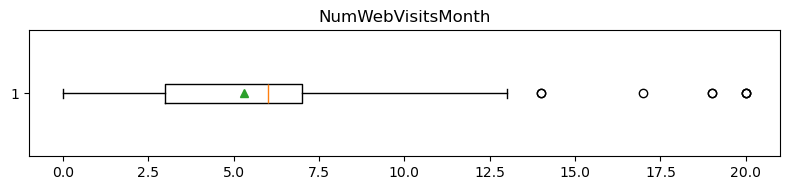

In [36]:
for i in dados_numericos:
    plt.figure(figsize=(8, 2))
    plt.boxplot(df[i], vert=False, showmeans=True)
    plt.title(i)
    plt.tight_layout()
    plt.show()

In [37]:
# A coluna YearBirth tem usuários com mais de 100 anos

# Ajustando os outliers por meio da mediana
df.loc[df['YearBirth']<1940,'YearBirth'] = df['YearBirth'].median()

In [38]:
# A coluna Income tem um valor muito maior do que os demais
# Considerando que o Income pode ser a renda anual apenas o valor 666666 parece não ser factivel

# Ajustando o valor errado com a mediana
df.loc[df['Income']==666666,'Income'] = df['Income'].median()

### Analisando a distribuição

Distribuição não normal
p: 1.7402954122693333e-15
Shapiro: 0.9834153162544007


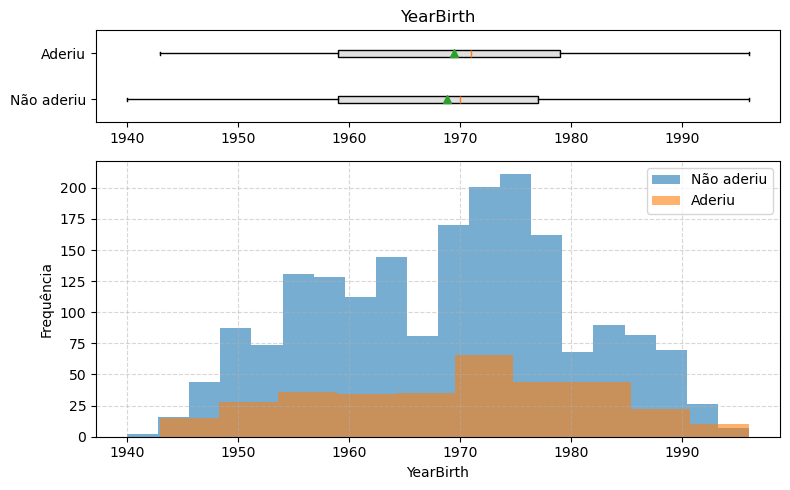

Distribuição não normal
p: 6.213876980656206e-19
Shapiro: 0.9760520537676692


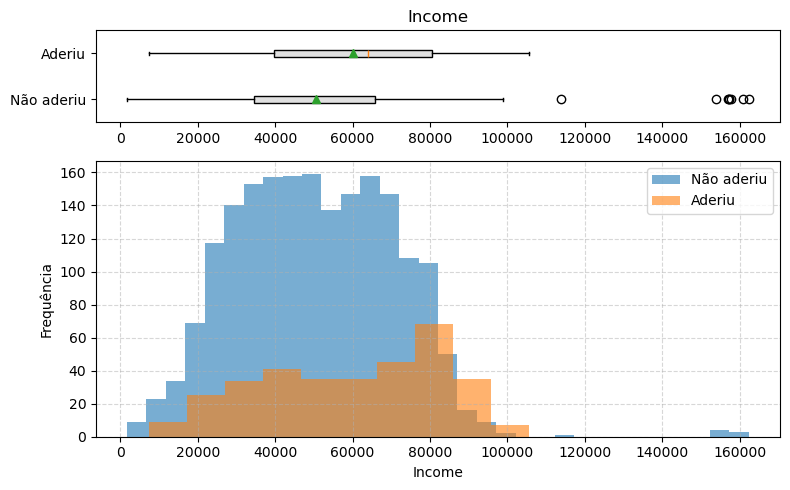

Distribuição não normal
p: 5.682848585682883e-26
Shapiro: 0.9540723881633597


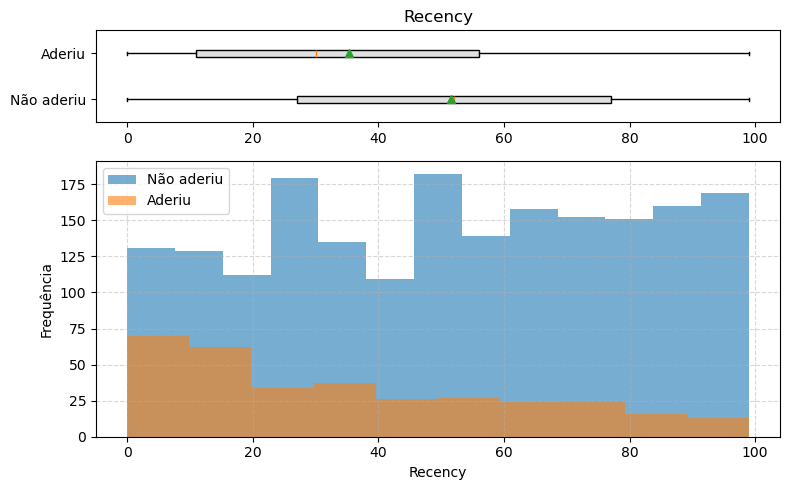

Distribuição não normal
p: 5.7062956880771855e-43
Shapiro: 0.8381434775681629


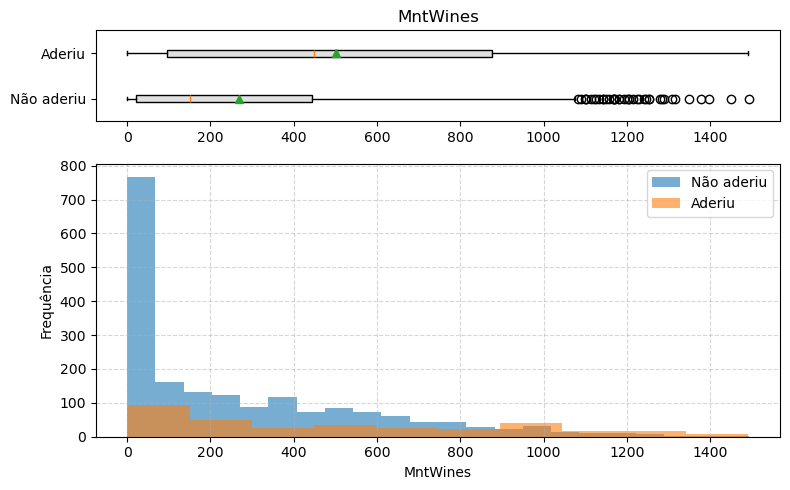

Distribuição não normal
p: 1.5424002227743575e-53
Shapiro: 0.689082024368662


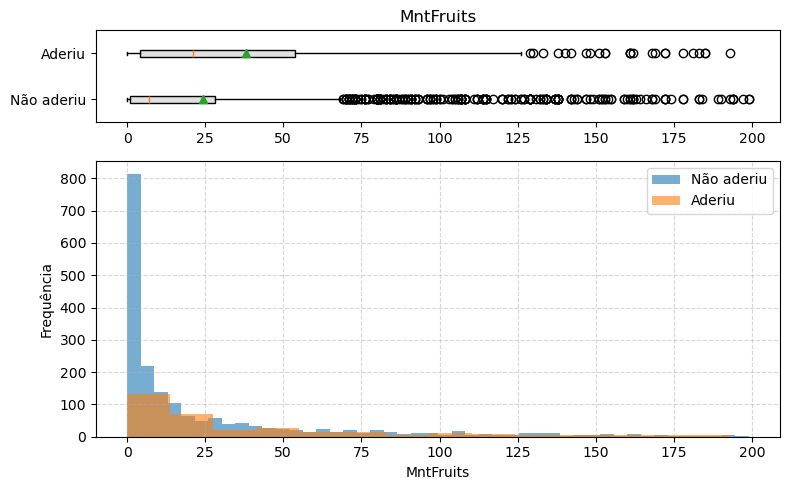

Distribuição não normal
p: 3.656336673723179e-51
Shapiro: 0.7298174322891932


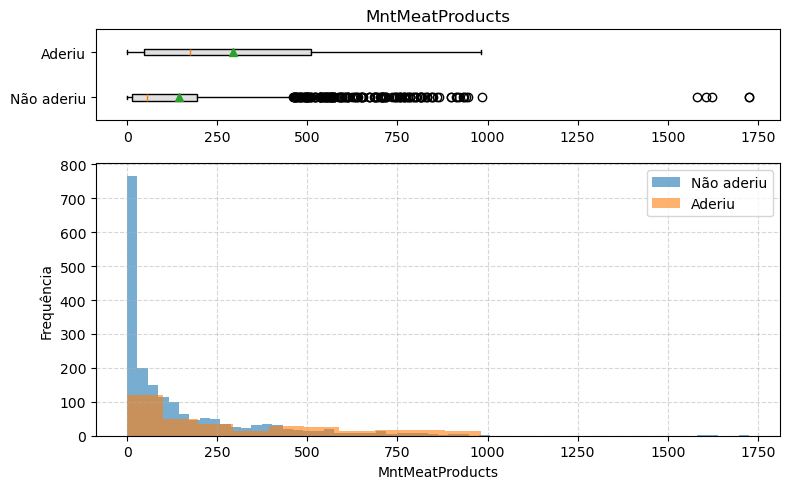

Distribuição não normal
p: 1.954643721371682e-52
Shapiro: 0.7085926071495632


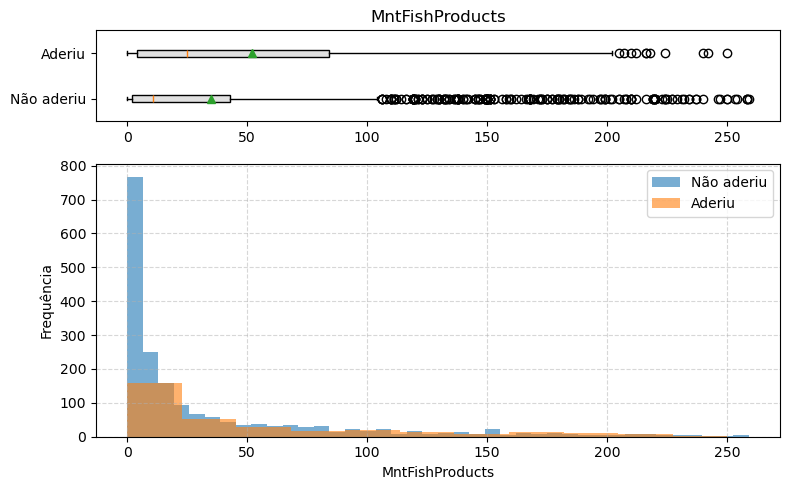

Distribuição não normal
p: 1.1484975093142203e-53
Shapiro: 0.6867474366038812


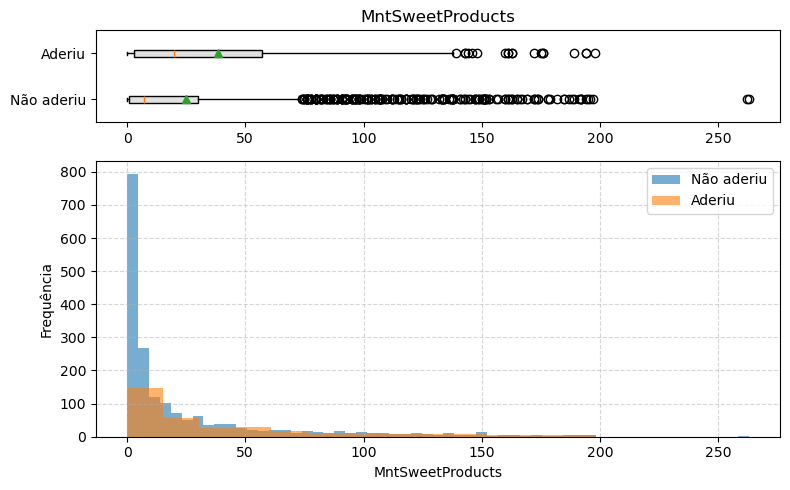

Distribuição não normal
p: 1.0300528046092174e-48
Shapiro: 0.7670888204468227


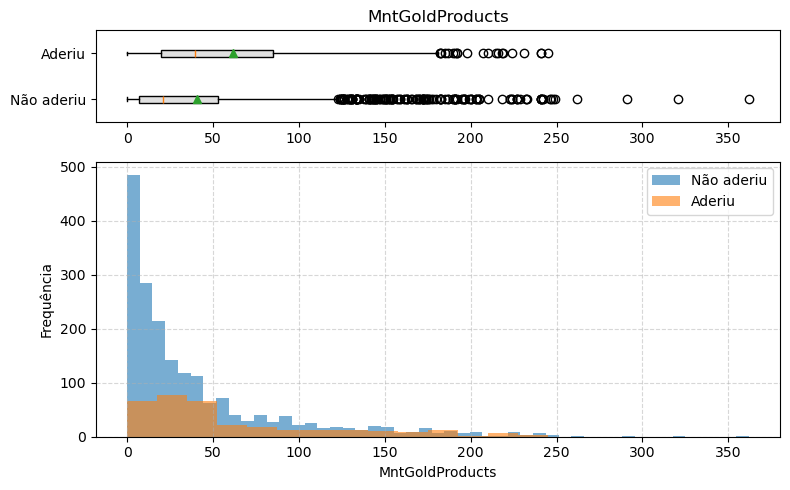

Distribuição não normal
p: 1.5505946976005412e-50
Shapiro: 0.7398039272769679


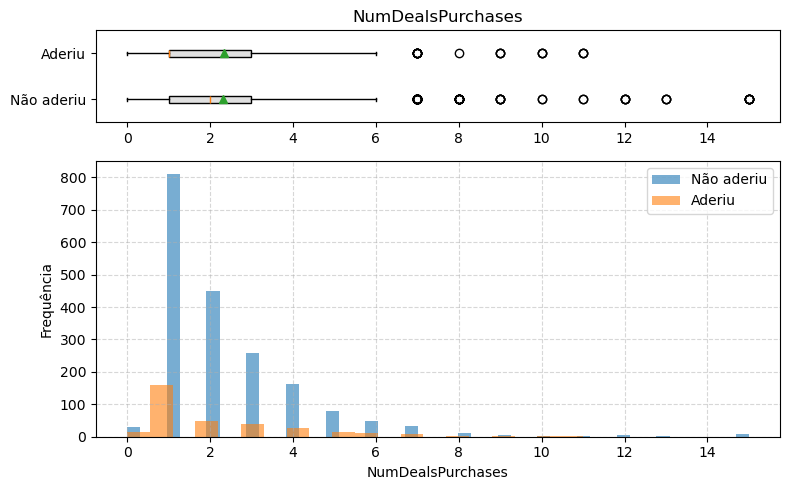

Distribuição não normal
p: 3.073409448456354e-36
Shapiro: 0.8978670841620069


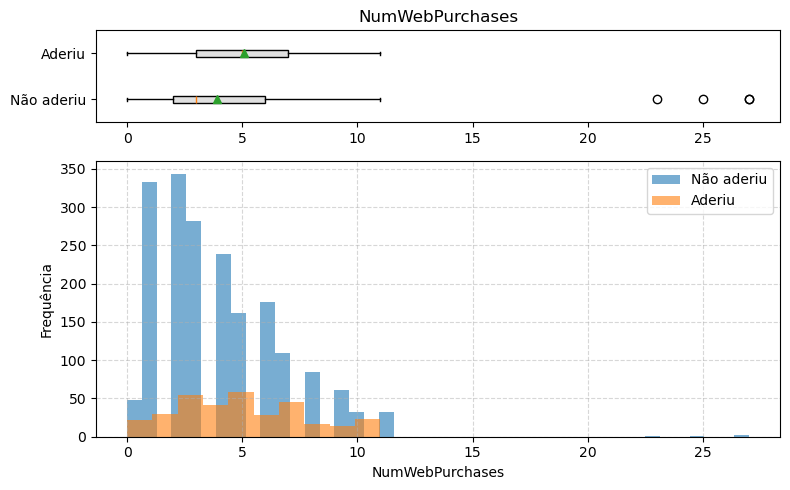

Distribuição não normal
p: 4.821937703087618e-45
Shapiro: 0.8149119321754595


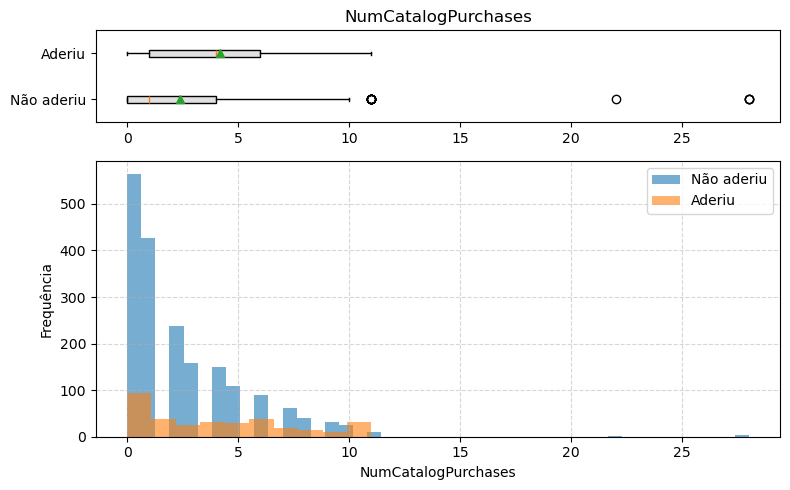

Distribuição não normal
p: 2.596487325188051e-35
Shapiro: 0.9044652689480432


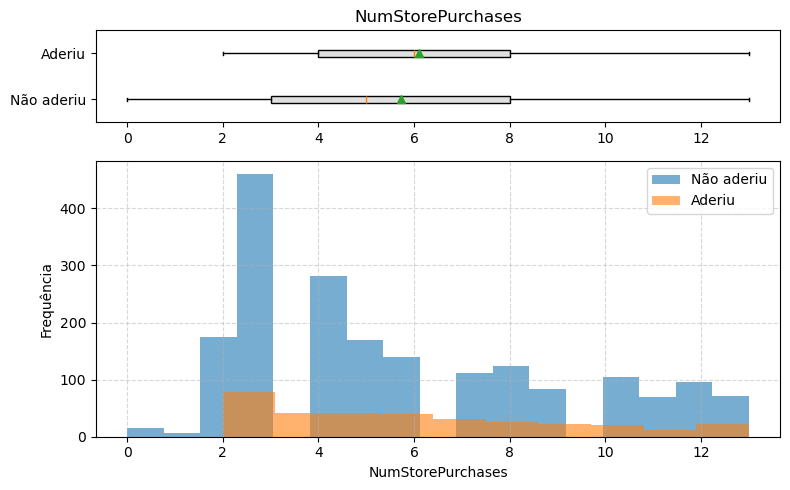

Distribuição não normal
p: 3.5193389386690543e-31
Shapiro: 0.9299013445635271


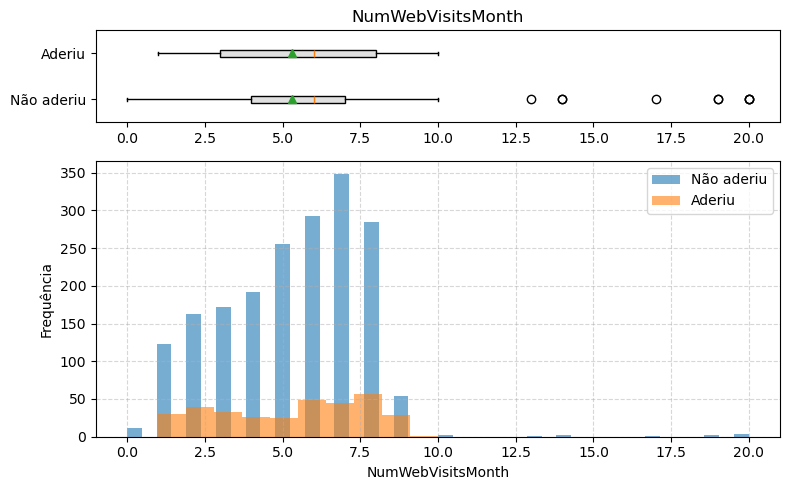

In [39]:
analisar_distribuicao_numerica(df, dados_numericos)


### Hipóteses

#### Ano de nascimento

H0: A chance de adesão a campanhas é igual entre usuários de diferentes faixas etárias

H1: Usuários mais jovens têm maior chance de adesão a campanhas do que os mais velhos

In [40]:
# Fazendo o teste de Wilcoxon para ter certeza de que a diferença é significativa
wilcoxon_test(df, column='YearBirth')

Resultado:
H₀ aceita, sem diferença estatística
p: 0.3482923188961873
U: 328525.5


#### Renda

H0: A chance de adesão a campanhas é igual entre usuários com diferentes níveis de renda

H1: Usuários com maior renda têm maior chance de adesão a campanhas do que os com menor renda

In [41]:
# Fazendo o teste de Wilcoxon para ter certeza de que a diferença é significativa
wilcoxon_test(df, column='Income')

Resultado:
H₀ rejeitada, diferença estatisticamente significativa
p: 3.19298344618884e-14
U: 401062.5


In [42]:
# Checando se a diferença é realmente pra mais
interpretar_diferenca(df, column='Income')

Mediana (grupo que aderiu): 64044.0
Mediana (grupo que não aderiu): 50567.0
Usuários que aderiram tendem a ter valores maiores dessa variável


#### Abandono

H0: A chance de adesão a campanhas é igual entre usuários com diferentes níveis de abandono

H1: Usuários com menor abandono têm maior chance de adesão a campanhas do que os com maior abandono

In [43]:
# Fazendo o teste de Wilcoxon para ter certeza de que a diferença é significativa
wilcoxon_test(df, column='Recency')

Resultado:
H₀ rejeitada, diferença estatisticamente significativa
p: 6.790861149893828e-21
U: 216066.0


In [44]:
# Checando se a diferença é realmente pra menos
interpretar_diferenca(df, column='Recency')

Mediana (grupo que aderiu): 30.0
Mediana (grupo que não aderiu): 52.0
Usuários que aderiram tendem a ter valores menores dessa variável


#### Gastos

H0: A chance de adesão a campanhas é igual entre usuários com diferentes níveis de gastos

H1: Usuários com mais gastos têm maior chance de adesão a campanhas do que os com menos gastos

In [45]:
gastos = ['MntWines', 'MntFruits','MntMeatProducts', 'MntFishProducts', 'MntSweetProducts','MntGoldProducts']

df['MntSumProducts'] = df[gastos].sum(axis=1).astype(int)

Distribuição não normal
p: 2.7805851314631663e-40
Shapiro: 0.8646703273311537


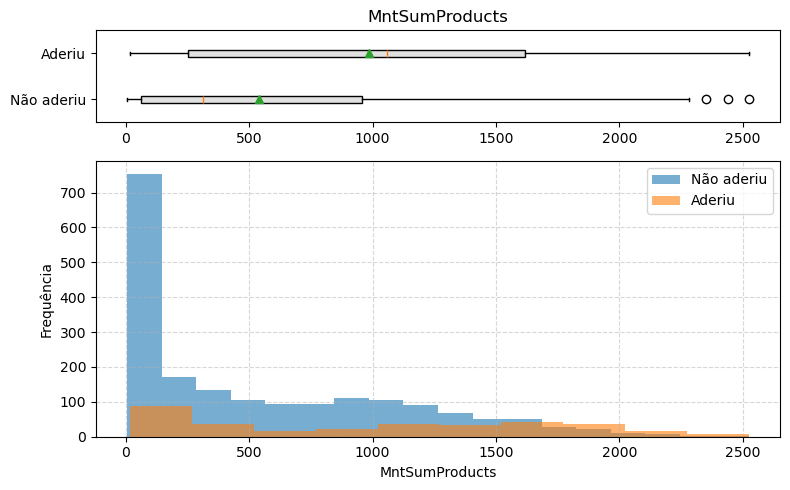

In [46]:
analisar_distribuicao_numerica(df, ['MntSumProducts'])

In [47]:
# Fazendo o teste de Wilcoxon para ter certeza de que a diferença é significativa
wilcoxon_test(df, column='MntSumProducts')

Resultado:
H₀ rejeitada, diferença estatisticamente significativa
p: 1.441166973008032e-29
U: 441421.5


In [48]:
# Checando se a diferença é realmente pra mais
interpretar_diferenca(df, column='MntSumProducts')

Mediana (grupo que aderiu): 1057.5
Mediana (grupo que não aderiu): 314.0
Usuários que aderiram tendem a ter valores maiores dessa variável


#### Compras

H0: A chance de adesão a campanhas é igual entre usuários com diferentes quantidades de compras

H1: Usuários com maior número de compras têm maior chance de adesão a campanhas do que os com menos compras

In [49]:
compras = ['NumDealsPurchases', 'NumWebPurchases','NumCatalogPurchases', 'NumStorePurchases']

df['MumSumPurchases'] = df[compras].sum(axis=1).astype(int)

Distribuição não normal
p: 6.082583956025573e-26
Shapiro: 0.9541879381579654


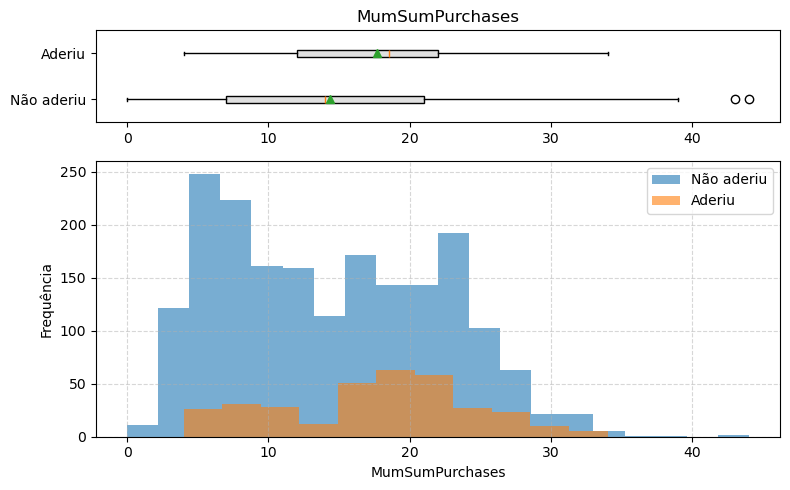

In [50]:
analisar_distribuicao_numerica(df, ['MumSumPurchases'])

In [51]:
# Fazendo o teste de Wilcoxon para ter certeza de que a diferença é significativa
wilcoxon_test(df, column='MumSumPurchases')

Resultado:
H₀ rejeitada, diferença estatisticamente significativa
p: 4.1910302679421567e-14
U: 400596.0


In [52]:
# Checando se a diferença é realmente pra mais
interpretar_diferenca(df, column='MumSumPurchases')

Mediana (grupo que aderiu): 18.5
Mediana (grupo que não aderiu): 14.0
Usuários que aderiram tendem a ter valores maiores dessa variável


#### Visitas web

H0: A chance de adesão a campanhas é igual entre usuários com diferentes quantidades de visitas ao site

H1: Usuários com mais visitas ao site têm maior chance de adesão a campanhas do que os com menos visitas

In [53]:
# Fazendo o teste de Wilcoxon para ter certeza de que a diferença é significativa
wilcoxon_test(df, column='NumWebVisitsMonth')

Resultado:
H₀ aceita, sem diferença estatística
p: 0.6114574646959319
U: 323793.5


---
## Segmentação de base

1. Nomalizar features
2. Testar numeros de clusters
3. Segmentar
4. Analisar diferenças

### Normalização das features

Features que serão ultilizadas:

- IsHighEducation: Se o cliente possui ensino superior (flag)
- IsAlone: Se vive sozinho (flag)
- HaveChildren: Se possui filhos (flag)
- IsAcceptedAny: Se aceitou ao menos uma campanha (flag)
- Income: Renda do usuário
- Recency: Dias desde a última compra
- MntSumProducts: Valor total gasto em produtos
- MumSumPurchases: Número total de compras

In [54]:
# Df da segmentação
df_cluster = df.copy()

features = [
     'IsHighEducation','IsAlone','HaveChildren','IsAcceptedAny',
     'Income','Recency','MntSumProducts','MumSumPurchases'
]

df_cluster[features] = df_cluster[features].astype(int)

# Normalizando a escala das features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[features])

### Teste de numero de clusters

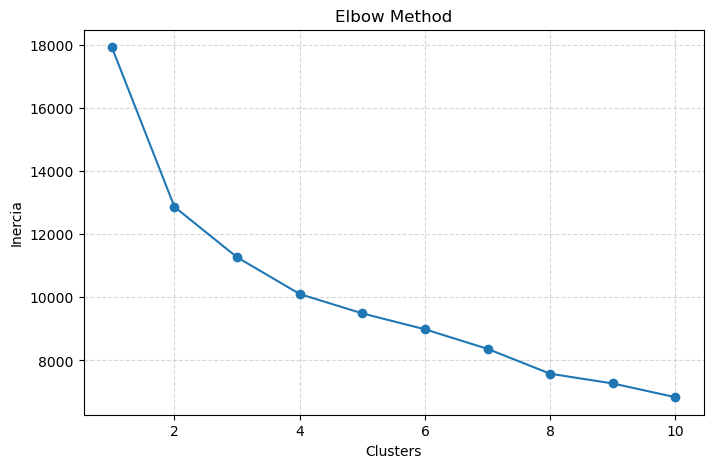

In [55]:
# Testando o numero de cluster pelo elbow method
inertias = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=4, n_init='auto')
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('Clusters')
plt.ylabel('Inercia')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Segmentação

In [56]:
kmeans = KMeans(n_clusters=2, random_state=4, n_init='auto')
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

# Medias das variaveis por cluster
cluster_profile = df_cluster.groupby('cluster')[features + ['Response']].mean().round(2)
cluster_profile['count'] = df_cluster['cluster'].value_counts()
cluster_profile.T

cluster,0,1
IsHighEducation,0.42,0.36
IsAlone,0.37,0.34
HaveChildren,0.48,0.89
IsAcceptedAny,0.38,0.08
Income,70725.73,37475.84
Recency,49.29,48.97
MntSumProducts,1186.49,157.42
MumSumPurchases,21.65,9.62
Response,0.22,0.09
count,976.00,1264.00


### Análise de diferenças

1. Entender as principais difernças entre os clusters
2. Nomea-los

#### PCA

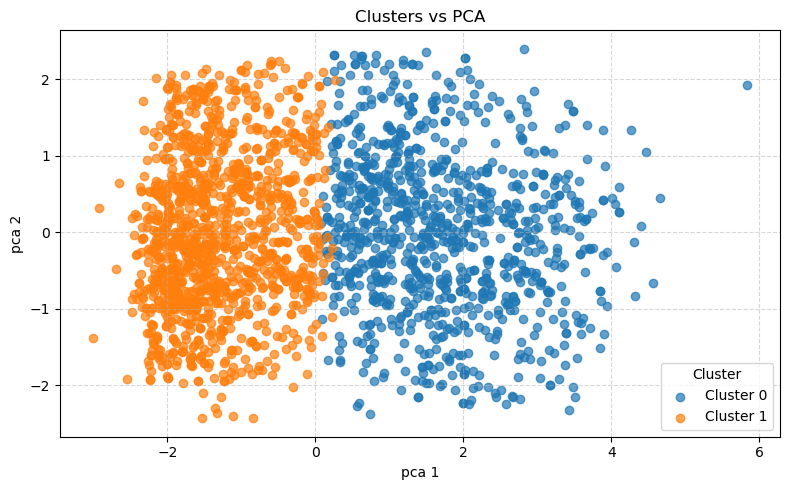

In [57]:
# Entendendo a separação dos clusters
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

df_cluster['pca_1'] = components[:, 0]
df_cluster['pca_2'] = components[:, 1]

plt.figure(figsize=(8, 5))
for cluster in sorted(df_cluster['cluster'].unique()):
    subset = df_cluster[df_cluster['cluster'] == cluster]
    plt.scatter(subset['pca_1'], subset['pca_2'], label=f'Cluster {cluster}', alpha=0.7)
plt.title('Clusters vs PCA')
plt.xlabel('pca 1')
plt.ylabel('pca 2')
plt.legend(title='Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#### Cluster vs Adesão

In [58]:
mostrar_adesao(df_cluster,['cluster'])

,cluster,Adesão,Amostra
0,0,22.44,976
1,1,9.10,1264


#### Dados categóricos

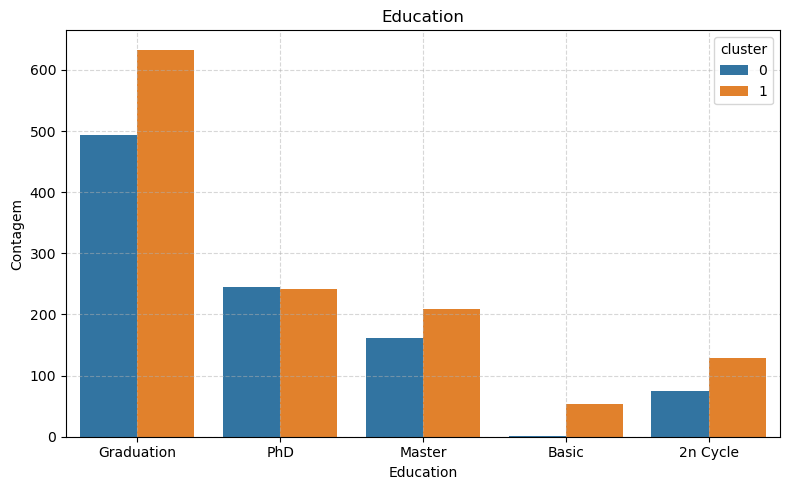

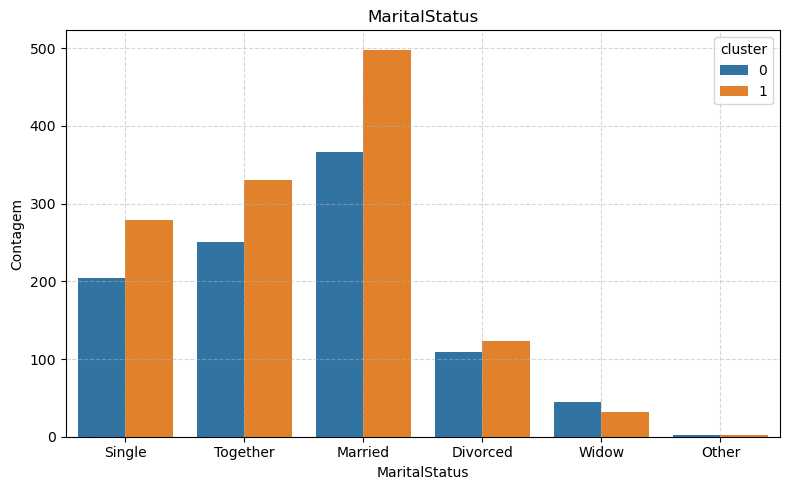

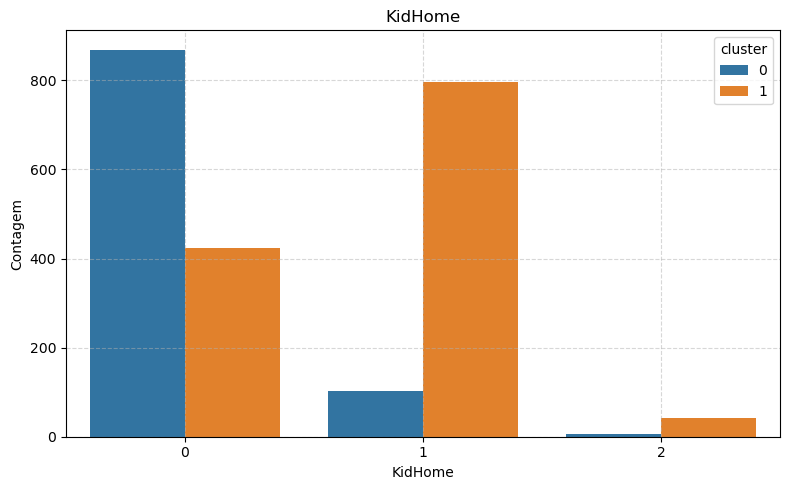

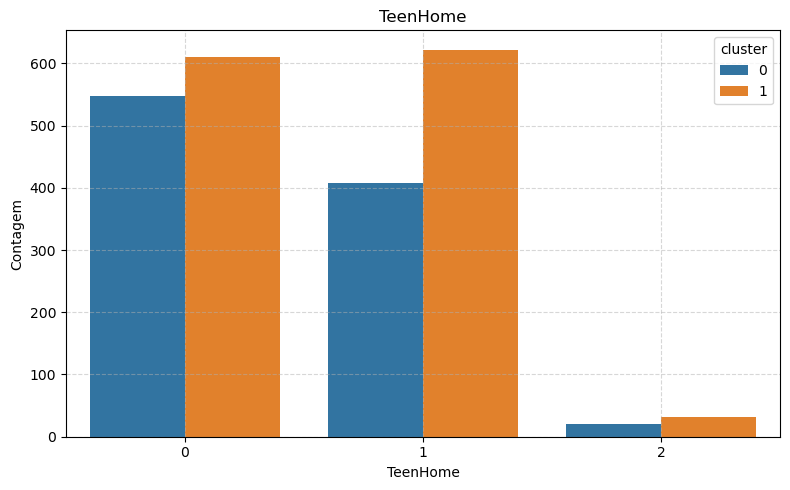

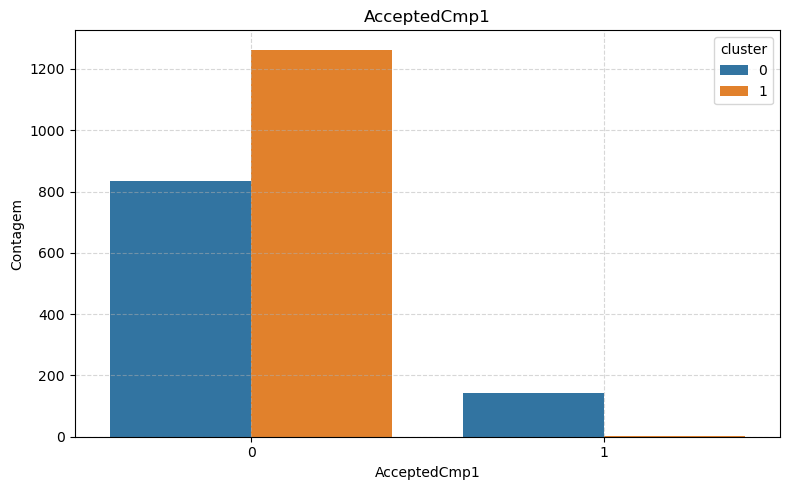

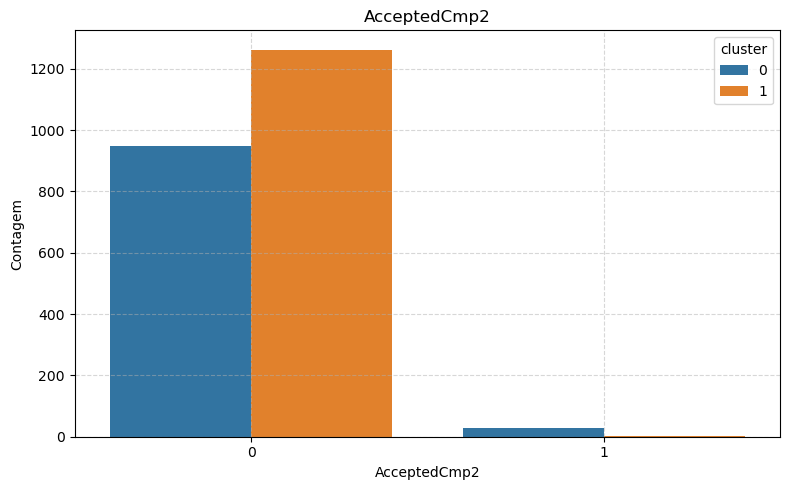

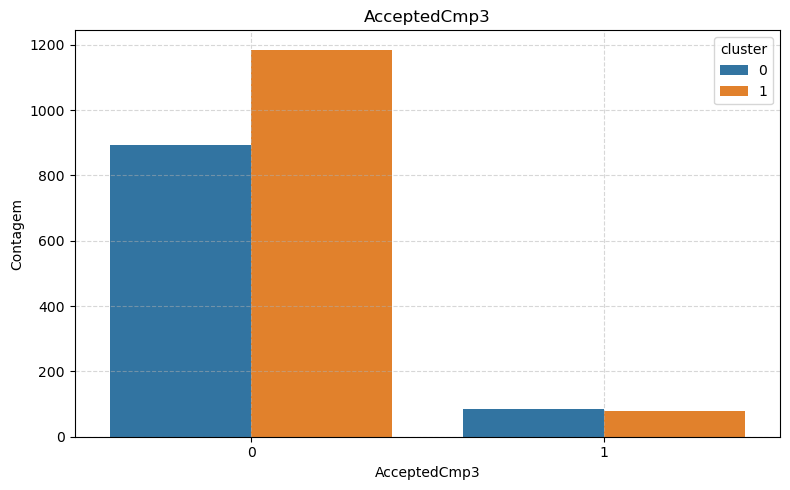

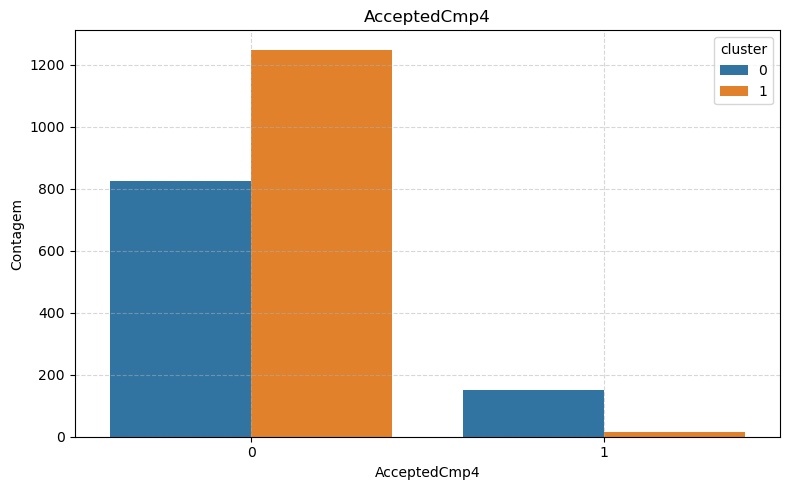

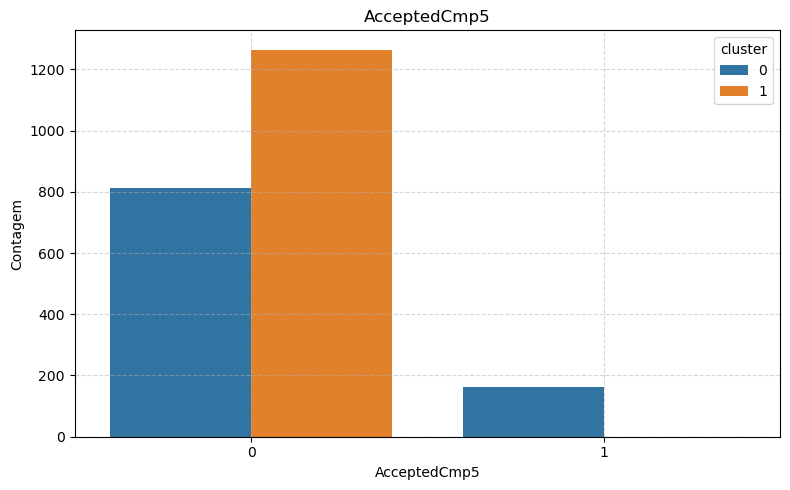

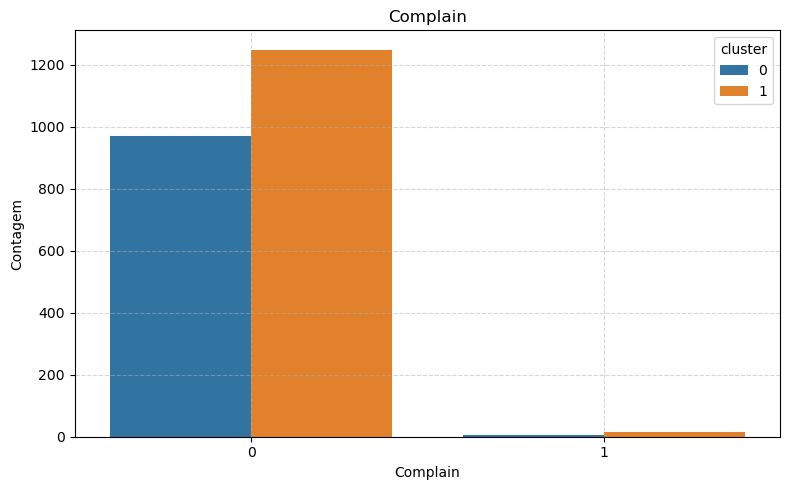

In [59]:
analisar_distribuicao_categorica(df_cluster, dados_categoricos, target='cluster')

#### Dados numéricos

Distribuição não normal
p: 1.7402954122693333e-15
Shapiro: 0.9834153162544007


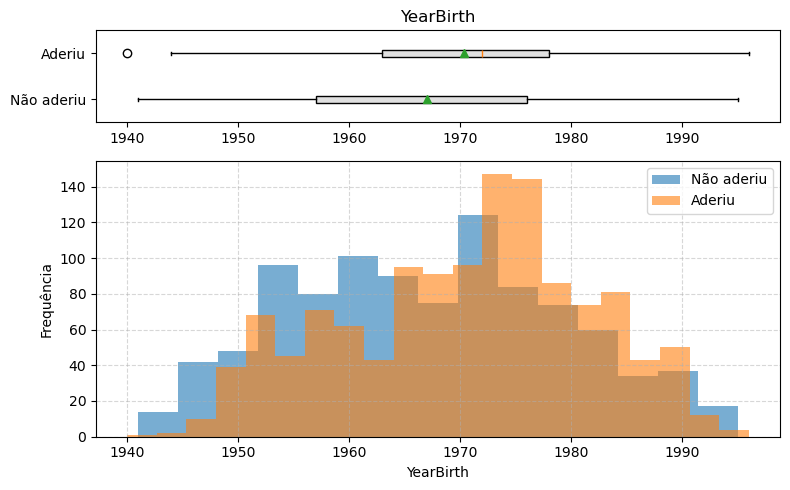

Distribuição não normal
p: 6.213876980656206e-19
Shapiro: 0.9760520537676692


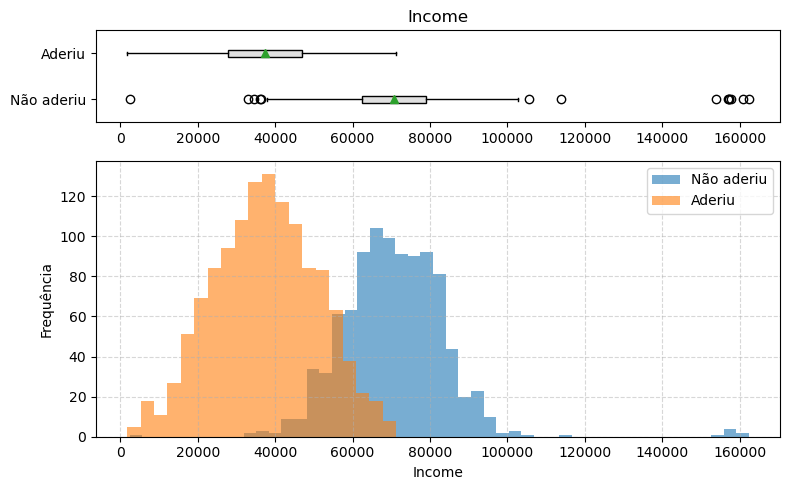

Distribuição não normal
p: 5.682848585682883e-26
Shapiro: 0.9540723881633597


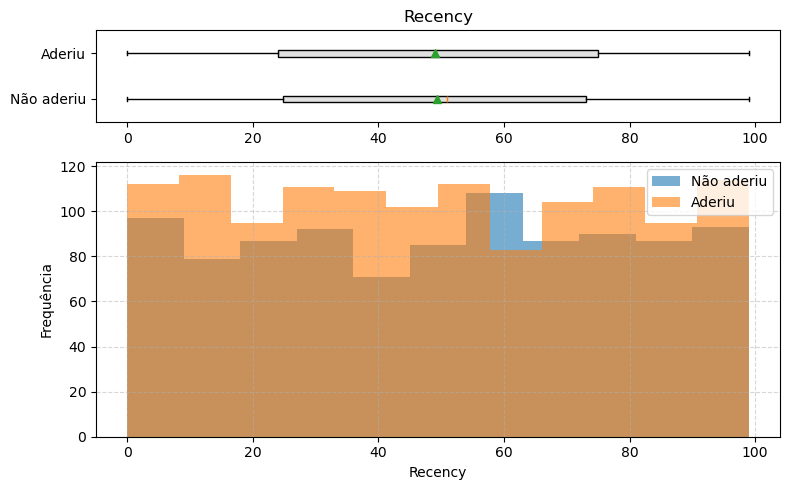

Distribuição não normal
p: 5.7062956880771855e-43
Shapiro: 0.8381434775681629


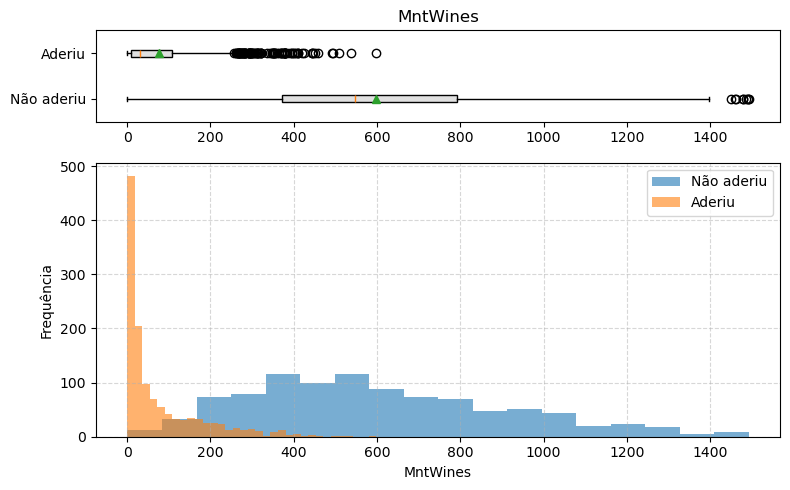

Distribuição não normal
p: 1.5424002227743575e-53
Shapiro: 0.689082024368662


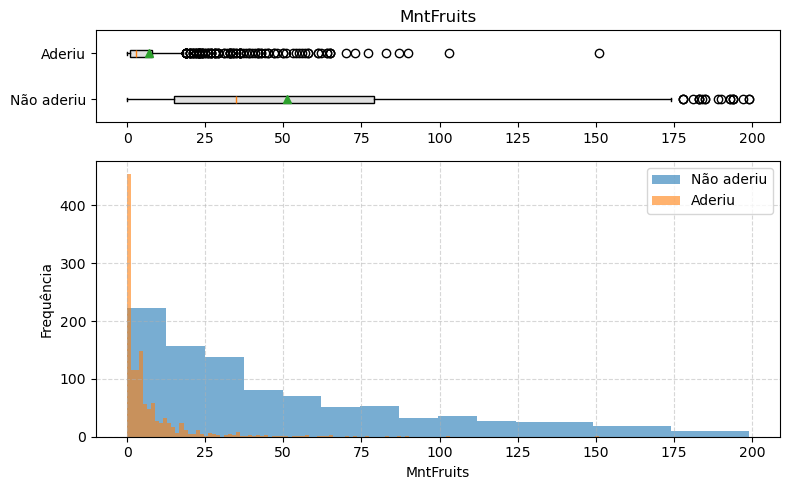

Distribuição não normal
p: 3.656336673723179e-51
Shapiro: 0.7298174322891932


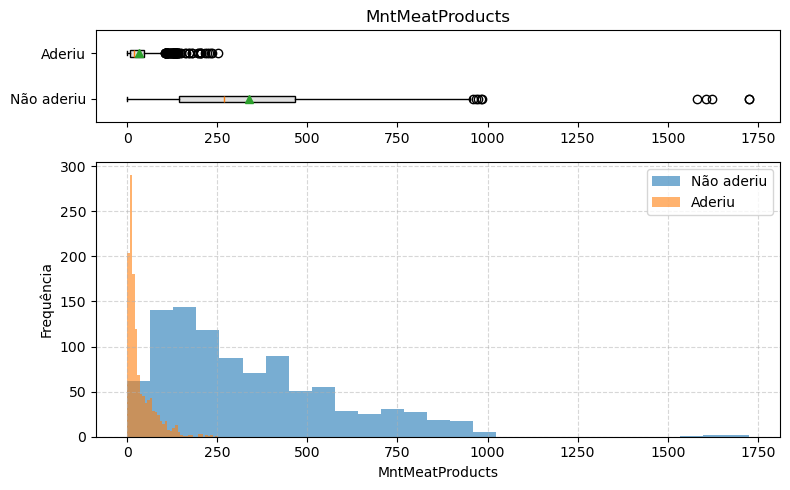

Distribuição não normal
p: 1.954643721371682e-52
Shapiro: 0.7085926071495632


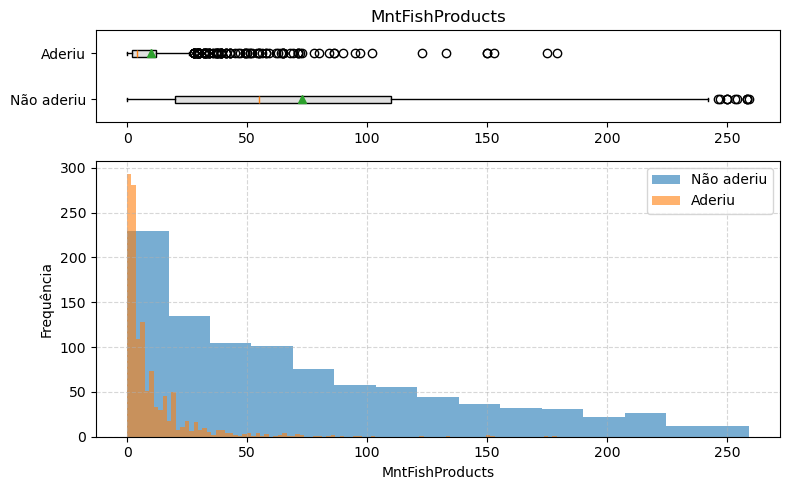

Distribuição não normal
p: 1.1484975093142203e-53
Shapiro: 0.6867474366038812


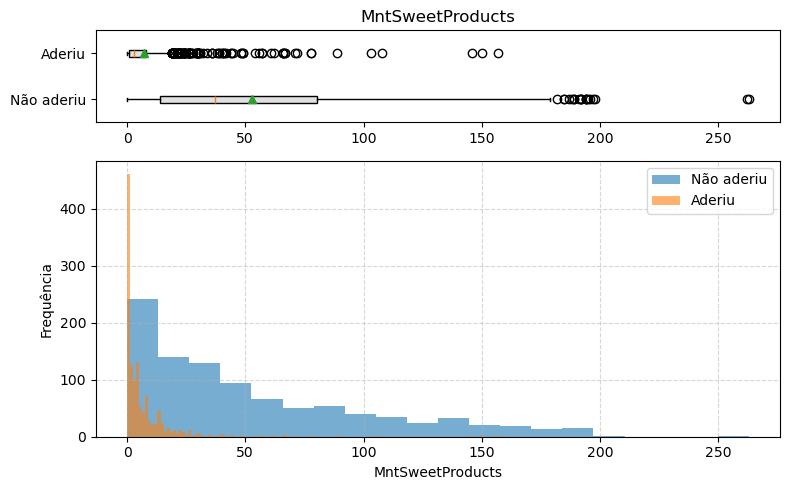

Distribuição não normal
p: 1.0300528046092174e-48
Shapiro: 0.7670888204468227


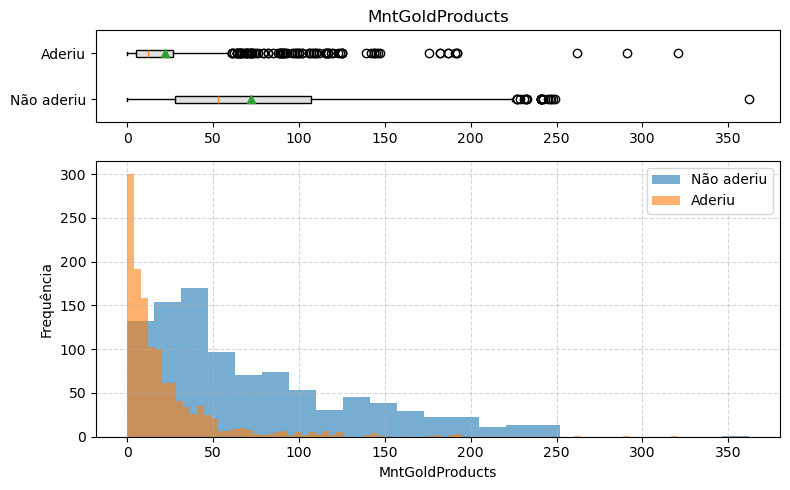

Distribuição não normal
p: 1.5505946976005412e-50
Shapiro: 0.7398039272769679


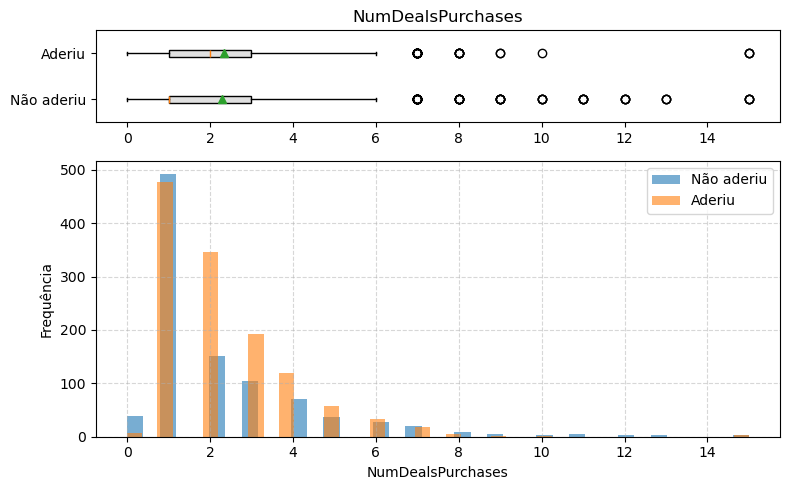

Distribuição não normal
p: 3.073409448456354e-36
Shapiro: 0.8978670841620069


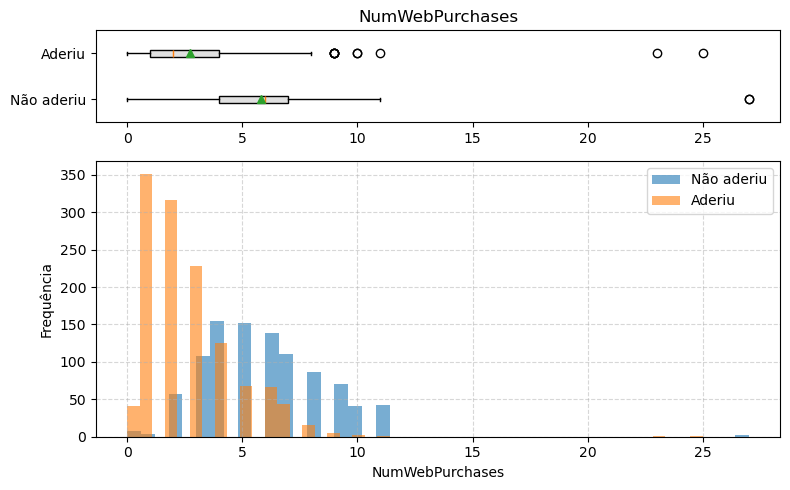

Distribuição não normal
p: 4.821937703087618e-45
Shapiro: 0.8149119321754595


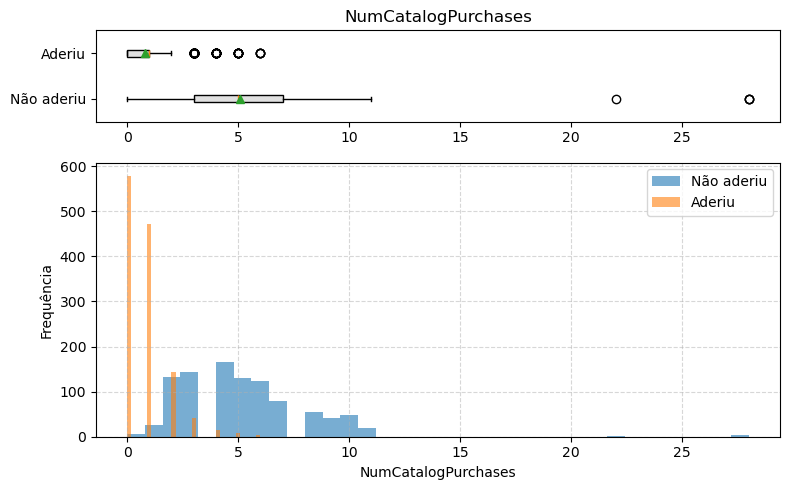

Distribuição não normal
p: 2.596487325188051e-35
Shapiro: 0.9044652689480432


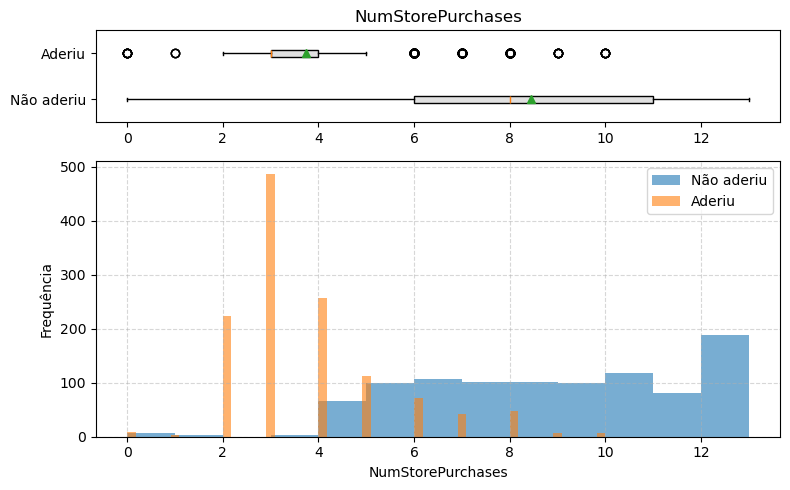

Distribuição não normal
p: 3.5193389386690543e-31
Shapiro: 0.9299013445635271


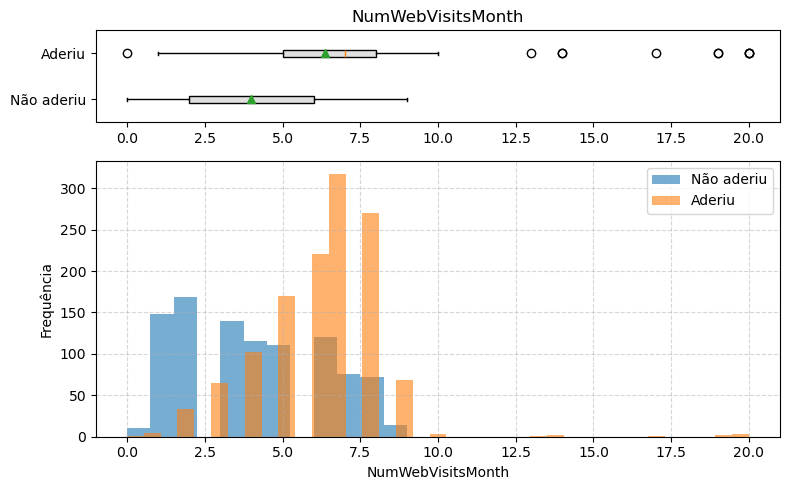

In [60]:
analisar_distribuicao_numerica(df_cluster, dados_numericos, target='cluster')

Cluster 0 – Engajados Jovens
- Maior taxa de adesão a novas campanhas: 22,4%
- Menor número de usuários: 976
- Filhos: Tendem a não ter filhos ou ter menos filhos
- Idade: Usuários mais jovens
- Renda: Ganham menos
- Gastos totais: Gastam menos
- Número de compras: Compram menos
- Visitas ao site: Visitam mais o site
- Adesão a campanhas anteriores: Maior engajamento
- Escolaridade: Distribuição semelhante ao outro grupo, exceto pelo nível “Basic”, menos presente aqui
- Estado civil e reclamações: Sem grandes diferenças em relação ao outro cluster

Cluster 1 – Desengajados Estáveis
- Menor taxa de adesão a novas campanhas: 9,1%
- Maior número de usuários: 1.264
- Filhos: Tendem a ter filhos
- Idade: Usuários mais velhos
- Renda: Ganham mais
- Gastos totais: Gastam mais
- Número de compras: Compram mais
- Visitas ao site: Visitam menos o site
- Adesão a campanhas anteriores: Menor engajamento
- Escolaridade: Maior concentração de pessoas com escolaridade básica (“Basic”)
- Estado civil e reclamações: Distribuição similar ao Cluster 0

---
# Modelo

## Separação de treino e teste

In [61]:
# Df para o modelo
df_model = df.copy()

features = [
    'IsHighEducation','IsAlone','HaveChildren','IsAcceptedAny',
    'Income','Recency','MntSumProducts','MumSumPurchases'
]

X = df_model[features]
y = df_model['Response']

# Criando bases de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=4)

## Normalização das features

In [62]:
# Normalizando a escala das features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Treino do modelo

In [63]:
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

# Gerando as probabilidades da classe positiva para a base de teste
X_test_probs = logreg.predict_proba(X_test_scaled)[:, 1]

# Avaliando a performance do modelo com o AUC (Área sob a Curva ROC)
print("AUC:", roc_auc_score(y_test, X_test_probs))

AUC: 0.8074688691874415


AUC: 0.8074688691874415


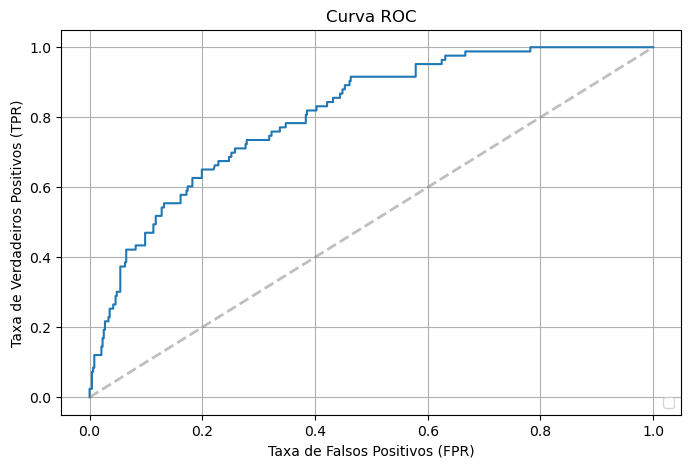

In [64]:
# Calculando os valores da curva ROC
fpr, tpr, thresholds = roc_curve(y_test, X_test_probs)

# Calculando AUC
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', alpha=0.5)
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Avaliação de thresholds

In [65]:
df_result = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
df_result['prob_response'] = X_test_probs
df_result['Response'] = y_test
df_result['ZCostContact'] = df_model.loc[df_result.index, 'ZCostContact']
df_result['ZRevenue'] = df_model.loc[df_result.index, 'ZRevenue']

# Simulando varios thresholds
thresholds = np.arange(0.0, 1.01, 0.01)
results = []

for t in thresholds:
    selected = df_result[df_result['prob_response'] >= t]
    cost = selected['ZCostContact'].sum()
    revenue = selected.loc[selected['Response'] == 1, 'ZRevenue'].sum()
    net_value = revenue - cost
    results.append((t, len(selected), cost, revenue, net_value))

df_eval = pd.DataFrame(results, columns=['threshold', 'n_contacts', 'cost', 'revenue', 'net_value'])

# Top 5 thresholds
df_eval.sort_values(by='net_value', ascending=False).head()

,threshold,n_contacts,cost,revenue,net_value
46,0.46,66,198,385,187
45,0.45,67,201,385,184
44,0.44,68,204,385,181
30,0.30,110,330,506,176
32,0.32,100,300,473,173


In [66]:
threshold = 0.46

df_result['predicted'] = (df_result['prob_response'] >= threshold).astype(int)

y_true = df_result['Response']
y_pred = df_result['predicted']

# Calculando a acuracia do threshold
accuracy = accuracy_score(df_result['Response'], df_result['predicted'])
print('acuracia: ',accuracy, '\n')

# Criando matrix de confusão do threshold
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

print('verdadeiros positivos (vp): ', tp)
print('falsos positivos (fp): ', fp)
print('verdadeiros negativos (vn): ', tn)
print('falsos negativos (fn): ', fn)

acuracia:  0.8589285714285714 

verdadeiros positivos (vp):  35
falsos positivos (fp):  31
verdadeiros negativos (vn):  446
falsos negativos (fn):  48


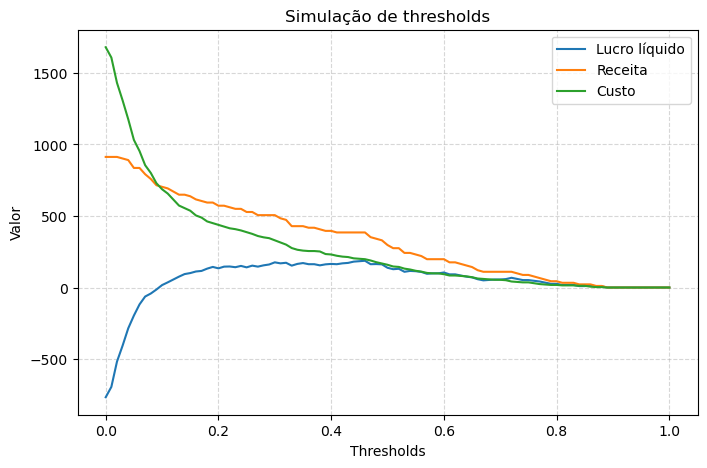

In [67]:
# Lucro, receita e custo por threshold
plt.figure(figsize=(8, 5))
plt.plot(df_eval['threshold'], df_eval['net_value'], label='Lucro líquido')
plt.plot(df_eval['threshold'], df_eval['revenue'], label='Receita')
plt.plot(df_eval['threshold'], df_eval['cost'], label='Custo')
plt.xlabel('Thresholds')
plt.ylabel('Valor')
plt.title('Simulação de thresholds')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## Ideia de sujestão

In [68]:
# Valores do cluster 0
df_cluster_engajado = df_cluster[df_cluster['cluster'] == 0]
cluster_receita = df_cluster_engajado.loc[df_cluster_engajado['Response'] == 1, 'ZRevenue'].sum()
cluster_custo = df_cluster_engajado['ZCostContact'].sum()
cluster_lucro = cluster_receita - cluster_custo
cluster_contatos = len(df_cluster_engajado)
cluster_adesao = round(df_cluster_engajado['Response'].sum() * 100 / cluster_contatos, 2)

# Valores do modelo
threshold = df_eval.sort_values(by='net_value', ascending=False).iloc[0]['threshold']
df_modelo_base = df_result[df_result['prob_response'] >= threshold]
modelo_receita = df_modelo_base.loc[df_modelo_base['Response'] == 1, 'ZRevenue'].sum()
modelo_custo = df_modelo_base['ZCostContact'].sum()
modelo_lucro = modelo_receita - modelo_custo
modelo_contatos = len(df_modelo_base)
modelo_adesao = round(df_modelo_base['Response'].sum() * 100 / modelo_contatos, 2)

pd.DataFrame({
    'Estratégia': ['Segmentação','Maior Lucro'],
    'Base usada': ['Cluster Engajado',f'Threshold ≥ {threshold:.2f}'],
    'Nº de Contatos': [cluster_contatos, modelo_contatos],
    'Taxa de Adesão (%)': [cluster_adesao, modelo_adesao],
    'Receita (R$)': [round(cluster_receita, 2), round(modelo_receita, 2)],
    'Custo (R$)': [round(cluster_custo, 2), round(modelo_custo, 2)],
    'Lucro Líquido (R$)': [round(cluster_lucro, 2), round(modelo_lucro, 2)]
})

,Estratégia,Base usada,Nº de Contatos,Taxa de Adesão (%),Receita (R$),Custo (R$),Lucro Líquido (R$)
0,Segmentação,Cluster Engajado,976,22.44,2409,2928,-519
1,Maior Lucro,Threshold ≥ 0.46,66,53.03,385,198,187
